In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
#import matplotlib.mlab as mlab
import cmocean
import cmocean.cm as cmo
from matplotlib.patches import Polygon
#-------------------------------------------------------------------------|
import seaborn as sns
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
from scipy.stats import norm as normm
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
import glob as glob
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pyresample.geometry import AreaDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.gridspec as gridspec
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [3]:
# Salinity unit
SaUnit = " g/kg"

# Loadind of dataset

In [4]:
Rep = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_Coloc/UpDate_colocs/SMOS_SMAP_and_InSitu/'
FILE = 'SMOS_and_SMAP_SSS_coloc_with_SASSIE_In_situ_data_with_axilia_full_Astrid_product_Radius_range_25_km.nc'
ds = xr.open_dataset(Rep+FILE)
ds

<xarray.Dataset>
Dimensions:                    (time: 1329112)
Coordinates:
  * time                       (time) float64 2.656e+04 2.656e+04 ... 2.66e+04
Data variables: (12/21)
    Longitude                  (time) float64 ...
    Latitude                   (time) float64 ...
    PSAL                       (time) float64 ...
    TEMP                       (time) float64 ...
    PSAL_mean                  (time) float64 ...
    TEMP_mean                  (time) float64 ...
    ...                         ...
    DEPTH                      (time) float64 ...
    DEPTH_mean                 (time) float64 ...
    SMAP_SSS_coloc             (time) float64 ...
    SMAP_ice_coloc             (time) float64 ...
    SMAP_uncert_coloc          (time) float64 ...
    Instruments                (time) float64 ...
Attributes:
    SASSIE_in_situ:         In situ data-set from SASSIE cruise
    SMOS_SSS:               SMOS SSS product for the Arctic Ocean (from Suppl...
    Creation_date_of_file:  2023-11-20T23:38:15Z
    Author_of_file:         Odilon Joel Houndegnonto, Severine Fournier and I...

In [5]:
DEPTH = np.array(ds.DEPTH)
isup10 = np.where(DEPTH<=10)[0]
isup10.size
print(f'Number of data point with first depth greater than 10m are: {np.where(DEPTH>10)[0].size} points \n while the ones lower or equal to 10m are {isup10.size} points')

Number of data point with first depth greater than 10m are: 19 points 
 while the ones lower or equal to 10m are 1329093 points


In [6]:
LON = np.array(ds.Longitude)[isup10]
LAT = np.array(ds.Latitude)[isup10]
Time = np.array(ds.time)[isup10]
SMOS = np.array(ds.SMOS_SSS_coloc)[isup10]
SMOS_uncert = np.array(ds.SMOS_uncert_coloc)[isup10]
SMAP = np.array(ds.SMAP_SSS_coloc[isup10])
SMAP_uncert = np.array(ds.SMAP_uncert_coloc[isup10])
SMAP_ice = np.array(ds.SMAP_ice_coloc[isup10])
PSAL = np.array(ds.PSAL)[isup10]
TEMP = np.array(ds.TEMP)[isup10]
PSAL_mean = np.array(ds.PSAL_mean)[isup10]
TEMP_mean = np.array(ds.TEMP_mean)[isup10]
DIST = np.array(ds.Dist_from_coast)[isup10]
ICE_PM = np.array(ds.ICE_conc_PM)[isup10]
ICE_Astrid = np.array(ds.ICE_conc_Astrid)[isup10]
Dist_edge_PM = np.array(ds.Dist_from_ice_edge_PM)[isup10]
Dist_edge_Astrid = np.array(ds.Dist_from_ice_edge_Astrid)[isup10]
WindSpeed = np.array(ds.Wind_speed)[isup10]
SST = np.array(ds.SST)[isup10]
DEPTH_mean = np.array(ds.DEPTH_mean)[isup10]
Instruments = np.array(ds.Instruments)[isup10]
DEPTH = np.array(ds.DEPTH)[isup10]

# Converting salinity PSU into Absolute salinity

In [7]:
# For Satellite SSS
SMOS_sa = gsw.SA_from_SP(SMOS,0,LON,LAT)
SMAP_sa = gsw.SA_from_SP(SMAP,0,LON,LAT)
# For in situ SSS
PSAL_sa = gsw.SA_from_SP(PSAL,DEPTH,LON,LAT)

Text(0, 0.5, 'g/kg')

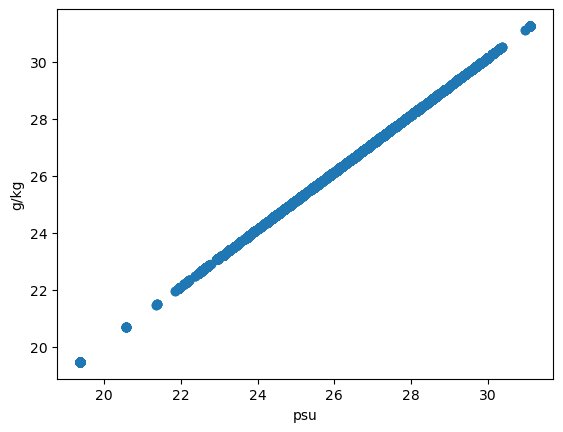

In [8]:
plt.plot(SMOS,SMOS_sa,'o')
plt.xlabel("psu")
plt.ylabel("g/kg")

In [9]:
# Here, in order to preserve the rest of the code, I will just recall the variable with their old name.
SMOS = SMOS_sa
SMAP = SMAP_sa
PSAL = PSAL_sa
del(SMOS_sa,SMAP_sa,PSAL_sa)

In [10]:
print(np.min(DEPTH),np.max(DEPTH))

0.02 10.0


In [11]:
Inst_label = [ "Alto Alamo","uCTD","cCTD","TSG","Wave Glider","JetSSP","SWIFT","UpTempO","Snake Salinity"]
Inst_label

['Alto Alamo',
 'uCTD',
 'cCTD',
 'TSG',
 'Wave Glider',
 'JetSSP',
 'SWIFT',
 'UpTempO',
 'Snake Salinity']

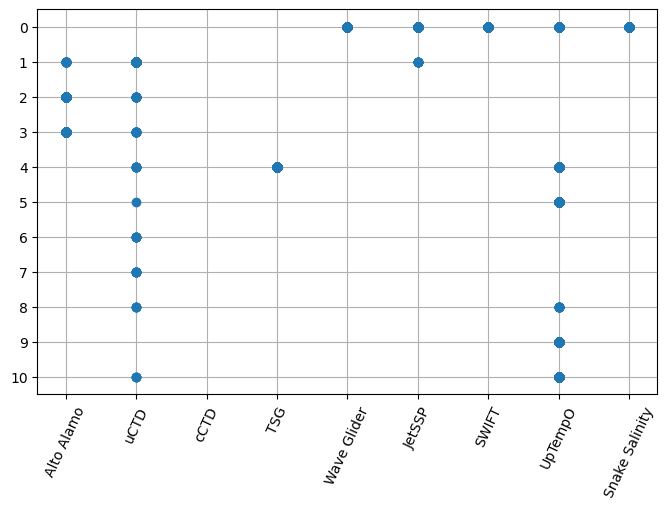

In [12]:
plt.figure(figsize=[8,5], num=2);plt.clf();
azar = plt.subplot(111)
plt.plot(Instruments,DEPTH.round(0),'o')
plt.xticks(np.arange(1,10,1),labels=Inst_label,rotation=65)
plt.yticks(np.arange(0,10.1,1))
azar.invert_yaxis();plt.grid()

(-2.0, 9.0)

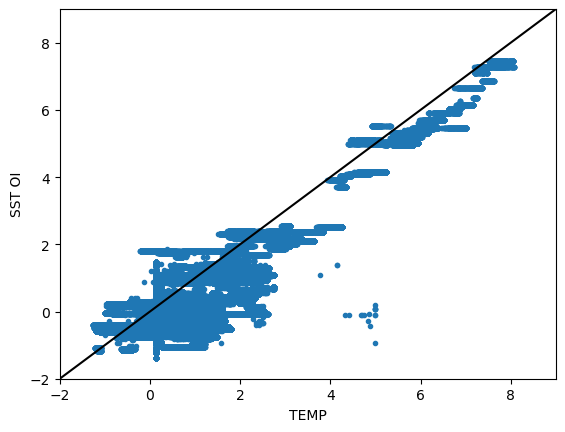

In [13]:
plt.plot(TEMP,SST,'.')
plt.plot([-2,9],[-2,9],'-k')
plt.xlabel("TEMP")
plt.ylabel("SST OI")
plt.xlim([-2,9])
plt.ylim([-2,9])

# Retrait des donnees outlier de UpTempO

inoneOutlier = np.where(~((Instruments==8) & ((SMAP<=21) | (PSAL<=20))))[0]
inoneOutlier.size

LON              = LON[inoneOutlier]
LAT              = LAT[inoneOutlier]
Time             = Time[inoneOutlier]
SMOS             = SMOS[inoneOutlier]
SMOS_uncert      = SMOS_uncert[inoneOutlier]
SMAP             = SMAP[inoneOutlier]
SMAP_uncert      = SMAP_uncert[inoneOutlier]
SMAP_ice         = SMAP_ice[inoneOutlier]
PSAL             = PSAL[inoneOutlier]
TEMP             = TEMP[inoneOutlier]
PSAL_mean        = PSAL_mean[inoneOutlier]
TEMP_mean        = TEMP_mean[inoneOutlier]
DIST             = DIST[inoneOutlier]
ICE_PM           = ICE_PM[inoneOutlier]
ICE_Astrid       = ICE_Astrid[inoneOutlier]
Dist_edge_PM     = Dist_edge_PM[inoneOutlier]
Dist_edge_Astrid = Dist_edge_Astrid[inoneOutlier]
WindSpeed        = WindSpeed[inoneOutlier]
SST              = SST[inoneOutlier]
DEPTH_mean       = DEPTH_mean[inoneOutlier]
Instruments      = Instruments[inoneOutlier]
DEPTH            = DEPTH[inoneOutlier]

# Comput of Correlation coefficient and RMSD

In [14]:
# For SMOS
R = np.round(ma.corrcoef(ma.masked_invalid(PSAL),ma.masked_invalid(SMOS))[0,1],2)
Rmsd = np.round(odi.odi_rmsd(PSAL,SMOS),2)
print(R,Rmsd)
# For SMAP
R2 = np.round(ma.corrcoef(ma.masked_invalid(PSAL),ma.masked_invalid(SMAP))[0,1],2)
Rmsd2 = np.round(odi.odi_rmsd(PSAL,SMAP),2)
print(R2,Rmsd2)

0.66 1.8
0.78 1.86


# Comput of linear regression fit between SMOS, SMAP and in situ 

In [15]:
# For SMOS
sal_insitu = np.arange(10,34.1,0.2).round(1)
P = np.polyfit(PSAL,SMOS,1)
sal_insitu_regress = np.polyval(P,sal_insitu)
# For SMAP
P2 = np.polyfit(PSAL,SMAP,1)
sal_insitu_regress2 = np.polyval(P2,sal_insitu)

iInstru = np.where(Instruments==8)[0]
iInstru

isup5 = np.where(DEPTH[iInstru]<=5)[0]
isup5

isall = np.where(((SMAP[iInstru][isup5]<=21) | (PSAL[iInstru][isup5]<=20)))[0]
isall.size

Instruments.size

plt.plot(DIST[iInstru][isup5][isall],'.')

plt.plot(Dist_edge_PM[iInstru][isup5][isall],'.')

plt.plot(Dist_edge_Astrid[iInstru][isup5][isall],'.')

max(Dist_edge_PM[iInstru][isup5][isall])

# Scatter plot SMOS vs in situ

In [16]:
smin = 12
smax = 34
sticks = np.arange(smin,smax+.1,2)
sticks

array([12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32., 34.])

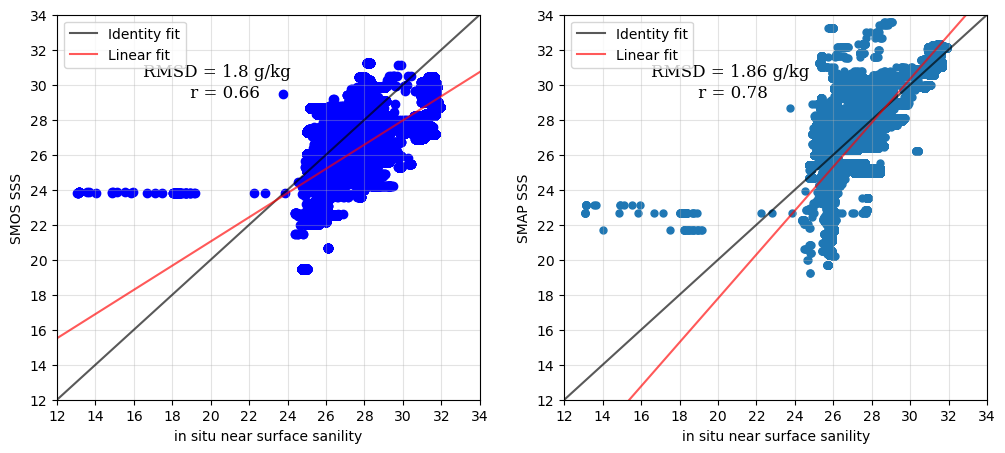

In [17]:
iInstru = np.where(Instruments==8)[0]
isup5 = np.where(DEPTH[iInstru]<=5)[0]

plt.figure(figsize=[12,5], num=2);plt.clf();
plt.subplot(121)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
#plt.scatter(PSAL,SMOS,s=25)
plt.plot(PSAL,SMOS,'ob',zorder=1)
#plt.plot(PSAL[iInstru][isup5][isall],SMOS[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMOS SSS')
plt.text(16.5,30.5,"RMSD = "+str(Rmsd)+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': 12,})
plt.text(16.5,29.3,"         r = "+str(R),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': 12,})
plt.legend(loc='upper left')
#---------------------------------------------------------------
plt.subplot(122)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress2,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
plt.scatter(PSAL,SMAP,s=25)
#plt.plot(PSAL[iInstru][isup5][isall],SMAP[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMAP SSS')
plt.text(16.5,30.5,"RMSD = "+str(Rmsd2)+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': 12,})
plt.text(16.5,29.3,"         r = "+str(R2),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': 12,})
plt.legend(loc='upper left')
#plt.savefig('/Users/houndegno/Documents/JupyterNoteBook/
#Figures/ScatterPlot-of-SMOS-vs-in-situ-data-SASSIE.png')

Text(0, 0.5, 'mean over top 5m')

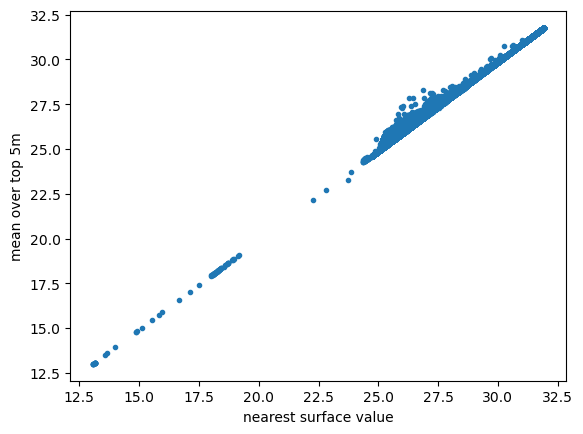

In [18]:
plt.plot(PSAL,PSAL_mean,'.')
plt.xlabel('nearest surface value')
plt.ylabel('mean over top 5m')
#plt.xlim(smin+5,smax)
#plt.ylim(smin+5,smax)

In [19]:
# For SMOS
Ra = np.round(ma.corrcoef(ma.masked_invalid(PSAL_mean),ma.masked_invalid(SMOS))[0,1],2)
Rmsda = np.round(odi.odi_rmsd(PSAL_mean,SMOS),2)
print(Ra,Rmsda)
# For SMAP
R2a = np.round(ma.corrcoef(ma.masked_invalid(PSAL_mean),ma.masked_invalid(SMAP))[0,1],2)
Rmsd2a = np.round(odi.odi_rmsd(PSAL_mean,SMAP),2)
print(R2a,Rmsd2a)

0.66 1.73
0.78 1.83


# Biases

In [20]:
SMOS_diff = SMOS-PSAL
SMAP_diff = SMAP-PSAL
SMOS_diff_mean = np.nanmean(SMOS_diff)
SMAP_diff_mean = np.nanmean(SMAP_diff)
SMOS_std = np.std(SMOS_diff)
SMAP_std = np.std(SMAP_diff)

In [21]:
print(min(SMOS_diff),max(SMOS_diff))
print(min(SMAP_diff),max(SMAP_diff))

-5.537709208299507 10.749808638171423
-6.052168138008177 10.015398474808867


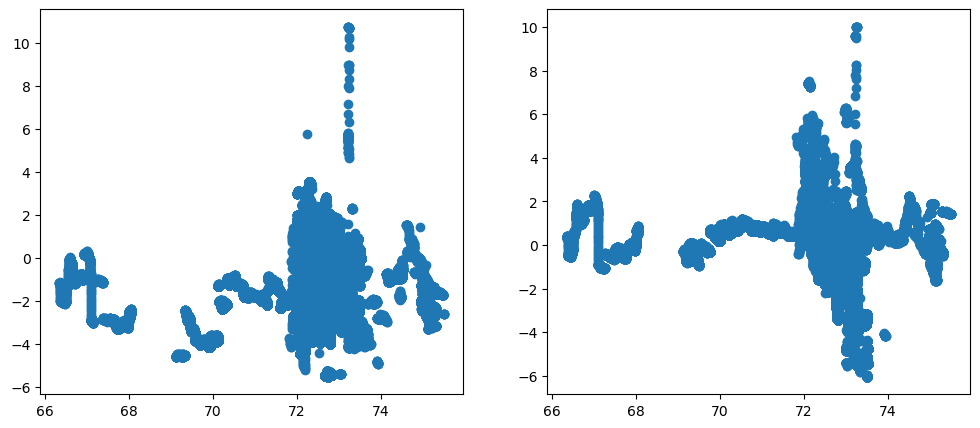

In [22]:
plt.figure(figsize=[12,5], num=2);plt.clf();
plt.subplot(121)
plt.plot(LAT,SMOS_diff,'o')
plt.subplot(122)
plt.plot(LAT,SMAP_diff,'o')

In [23]:
SMOS_fresh = (np.where(SMOS_diff<0)[0].size)*100/SMOS_diff.size
print("SMOS_fresh  ",np.round(SMOS_fresh,2))
SMOS_saltier = (np.where(SMOS_diff>0)[0].size)*100/SMOS_diff.size
print("SMOS_saltier",np.round(SMOS_saltier,2))

SMOS_fresh   76.48
SMOS_saltier 23.52


In [24]:
SMAP_fresh = (np.where(SMAP_diff<0)[0].size)*100/SMAP_diff.size
print("SMAP_fresh  ",np.round(SMAP_fresh,2))
SMAP_saltier = (np.where(SMAP_diff>0)[0].size)*100/SMAP_diff.size
print("SMAP_saltier",np.round(SMAP_saltier,2))

SMAP_fresh   52.88
SMAP_saltier 47.12


In [25]:
print(SMOS_diff_mean,SMAP_diff_mean)
print(SMOS_std,SMAP_std)

-1.0475107289161918 -0.4816866310531402
1.4668783805646604 1.7969718228686626


In [26]:
i_ice = np.where((ICE_Astrid>70) & (PSAL<20))[0]
i_ice.size

69

In [27]:
np.unique(Instruments[i_ice])

array([8.])

[1 = Alto_Alamo],
[2 = uCTD],
[3 = CTD],
[4 = TSG],
[5 = Wave_Glider],
[6 = JetSSP],
[7 = SWIFT],
[8 = UpTempO],
[9 = Snake_Salinity]

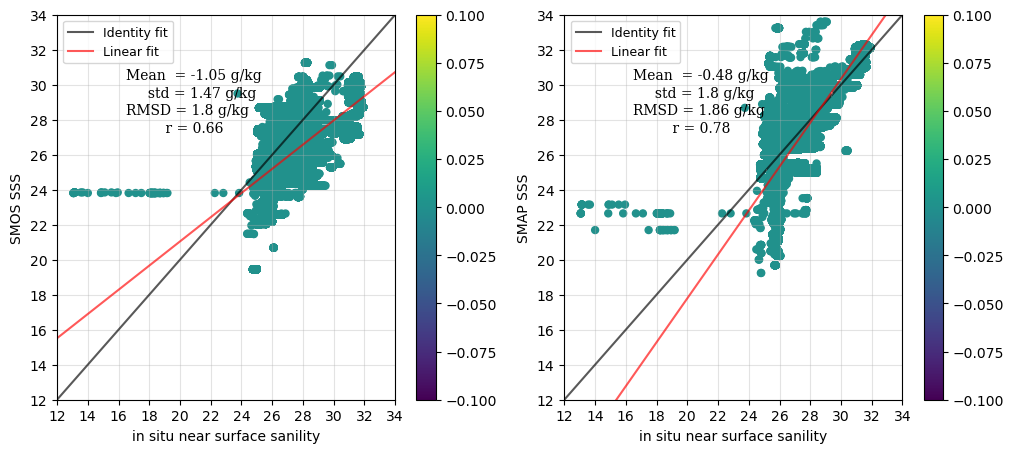

In [28]:
#iInstru = np.where(Instruments==8)[0]
#isup5 = np.where(DEPTH[iInstru]<=5)[0]
labsize = 10
plt.figure(figsize=[12,5], num=2);plt.clf();
plt.subplot(121)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
zata = plt.scatter(PSAL,SMOS,s=25,c=ICE_PM)
plt.colorbar(zata)
#plt.plot(PSAL[iInstru][isup5][isall],SMOS[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMOS SSS')
plt.text(16.5,30.3,"Mean  = "+str(SMOS_diff_mean.round(2))+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,29.3,"     std = "+str(SMOS_std.round(2))+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,28.3,"RMSD = "+str(Rmsd)+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,27.3,"         r = "+str(R),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left',fontsize=labsize-1)
#---------------------------------------------------------------
plt.subplot(122)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress2,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
zata = plt.scatter(PSAL,SMAP,s=25,c=ICE_PM)
plt.colorbar(zata)
#plt.plot(PSAL[iInstru][isup5][isall],SMAP[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMAP SSS')

plt.text(16.5,30.3,"Mean  = "+str(SMAP_diff_mean.round(2))+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,29.3,"     std = "+str(SMAP_std.round(2))+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,28.3,"RMSD = "+str(Rmsd2)+" g/kg",\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,27.3,"         r = "+str(R2),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left',fontsize=labsize-1)
#plt.savefig('/Users/houndegno/Documents/JupyterNoteBook/
#Figures/ScatterPlot-of-SMOS-vs-in-situ-data-SASSIE.png')

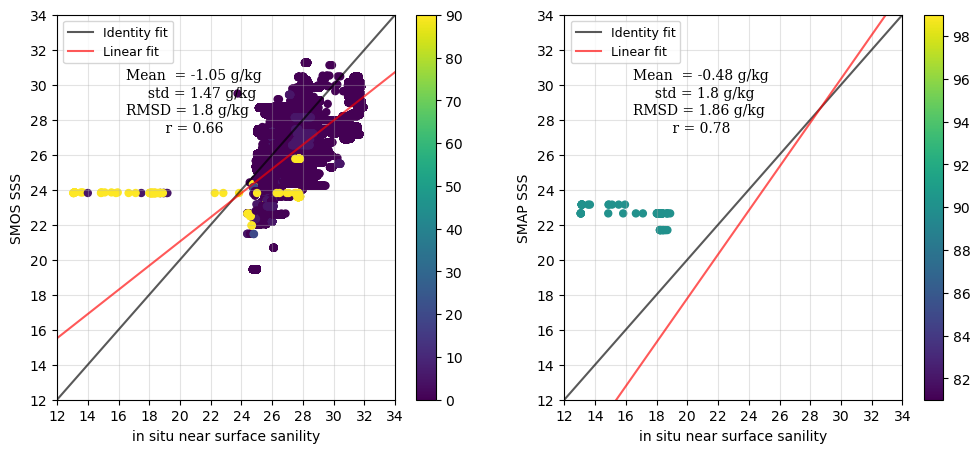

In [29]:
#iInstru = np.where(Instruments==8)[0]
#isup5 = np.where(DEPTH[iInstru]<=5)[0]
labsize = 10
plt.figure(figsize=[12,5], num=2);plt.clf();
plt.subplot(121)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
zata = plt.scatter(PSAL,SMOS,s=25,c=ICE_Astrid)
plt.colorbar(zata)
#plt.plot(PSAL[iInstru][isup5][isall],SMOS[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMOS SSS')
plt.text(16.5,30.3,"Mean  = "+str(SMOS_diff_mean.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,29.3,"     std = "+str(SMOS_std.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,28.3,"RMSD = "+str(Rmsd)+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,27.3,"         r = "+str(R),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left',fontsize=labsize-1)
#---------------------------------------------------------------
plt.subplot(122)
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress2,'-r',alpha=.65,zorder=2,label='Linear fit')
#---------------------------------------------------------------
zata = plt.scatter(PSAL[i_ice],SMAP[i_ice],s=25,c=ICE_Astrid[i_ice])
plt.colorbar(zata)
#plt.plot(PSAL[iInstru][isup5][isall],SMAP[iInstru][isup5][isall],'.r')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax)
plt.ylim(smin,smax)
plt.grid(alpha=.35)
plt.xlabel('in situ near surface sanility')
plt.ylabel('SMAP SSS')

plt.text(16.5,30.3,"Mean  = "+str(SMAP_diff_mean.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,29.3,"     std = "+str(SMAP_std.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,28.3,"RMSD = "+str(Rmsd2)+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(16.5,27.3,"         r = "+str(R2),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left',fontsize=labsize-1)
#plt.savefig('/Users/houndegno/Documents/JupyterNoteBook/
#Figures/ScatterPlot-of-SMOS-vs-in-situ-data-SASSIE.png')

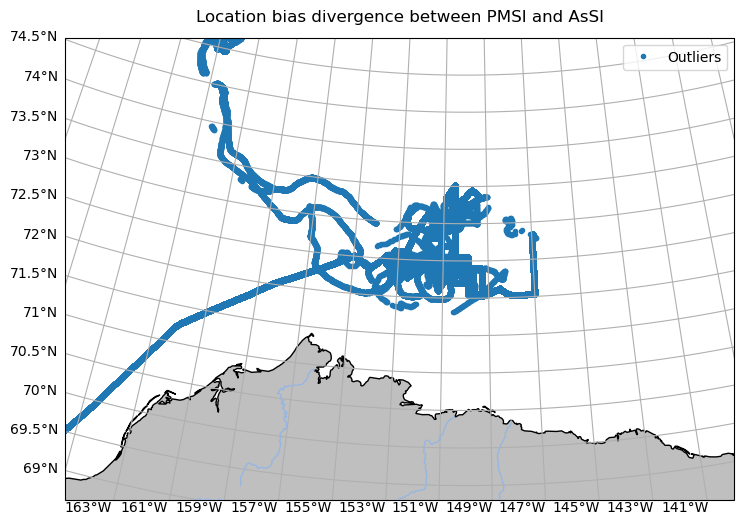

In [30]:
lon0=-150
lonmapmin=-165
lonmapmax=-140
latmapmin=69
latmapmax=75
#----------------------------------------------------------------------------#
time_selec = 47
#----------------------------------------------------------------------------#
fig = plt.figure(figsize=[10,6], num=2);plt.clf();
#ax = plt.axes(projection=ccrs.NorthPolarStereo())
# Limit the map to 45 degrees latitude and above.
ax1 = fig.add_subplot(projection=ccrs.NorthPolarStereo(central_longitude=lon0))
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], ccrs.PlateCarree())
#----------------------------------------------------------------------------#
ax1.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax1.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
ax1.coastlines('10m',zorder=2)
g1 = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False)
g1.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
g1.xformatter = LONGITUDE_FORMATTER
g1.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
g1.yformatter = LATITUDE_FORMATTER
g1.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
g1.ylabel_style = {'size': 10, 'color': 'k','rotation':0}
g1.top_labels = False
g1.right_labels = False
#------------------------------------------------------------------------------------------|
ax1.set_title('Location bias divergence between PMSI and AsSI')
ax1.plot(LON,LAT,'.',transform=ccrs.PlateCarree(),zorder=1, label='Outliers')#twilight
#ax1.plot(LON[iInstru][isup5][isall],LAT[iInstru][isup5][isall],'.r',
#         transform=ccrs.PlateCarree(),zorder=1, label='Outliers')#twilight
plt.legend()

Text(0, 0.5, 'SMAP SSS')

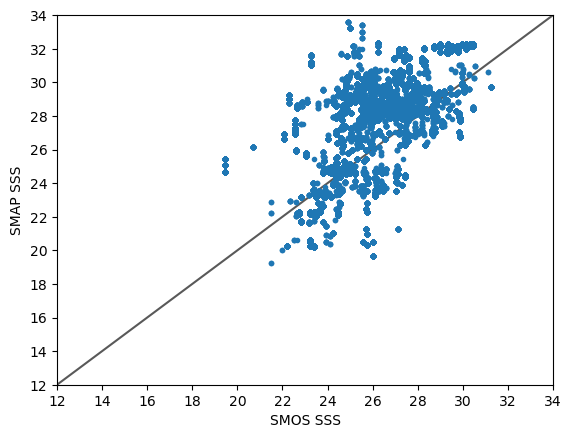

In [31]:
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
plt.plot(SMOS,SMAP,'.')
plt.xticks(sticks);plt.yticks(sticks)
plt.xlim(smin,smax);plt.ylim(smin,smax)
plt.xlabel('SMOS SSS');plt.ylabel('SMAP SSS')

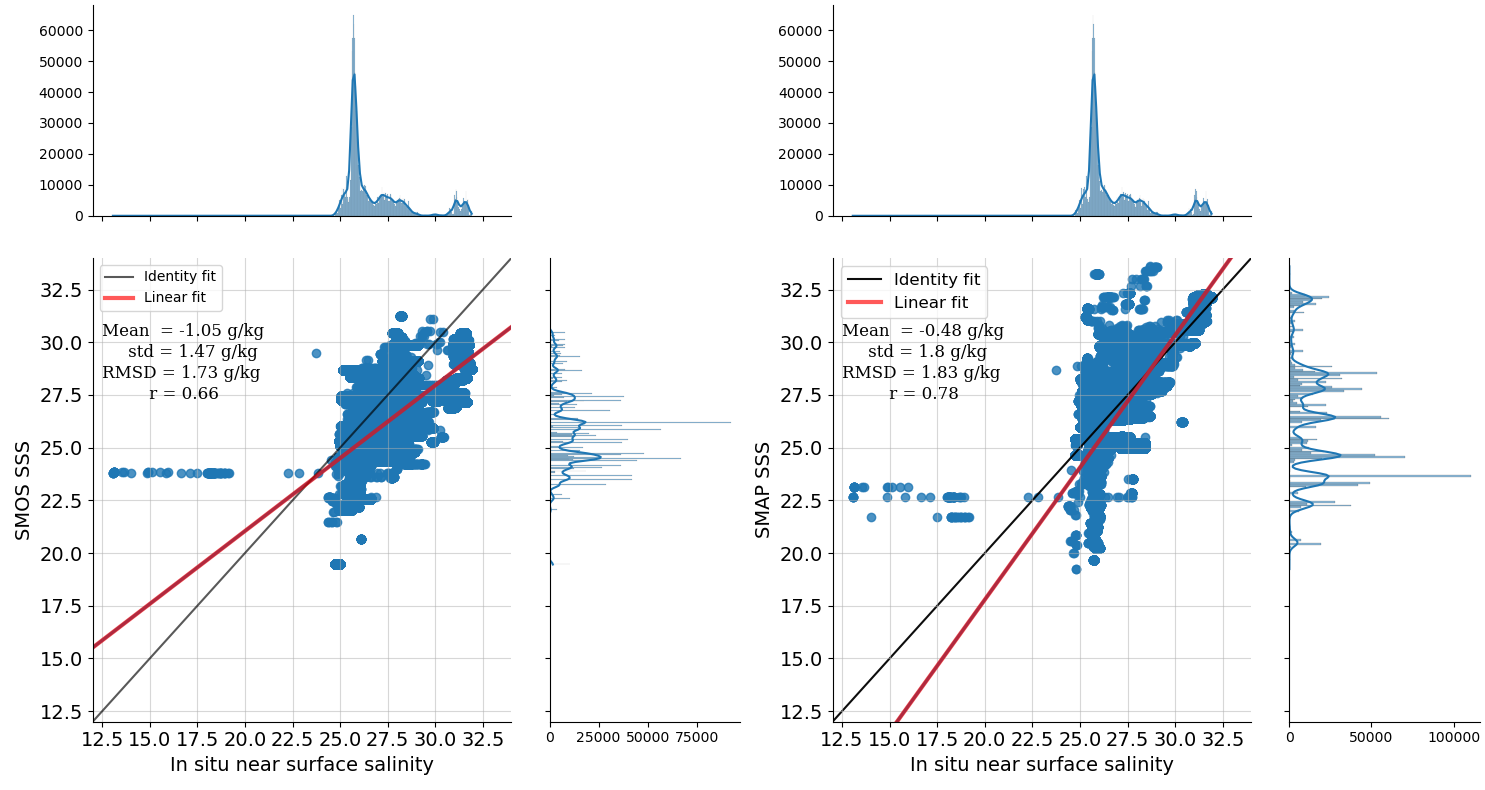

In [32]:
#plt.figure(figsize=[10,10], num=2);plt.clf();
labsize = 12
fig = plt.figure(figsize=[15, 8]);plt.clf()
#fig.subplots_adjust(bottom=0.25, top=0.9, left=0.08, right=0.95,
                     #hspace=0.4)
gs = gridspec.GridSpec(1, 2)#plt.subplot(121)
#asa = 14
#rc={'xtick.labelsize': asa, 'ytick.labelsize': asa}
#sns.set(rc=rc)

A1 = sns.jointplot(x=PSAL, y=SMOS, kind="reg",
              xlim=(smin, smax), ylim=(smin, smax),truncate=False, marginal_ticks=True, ratio=2)##4CB391
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
plt.xlabel("In situ near surface salinity",fontsize=14)
#--
##A1.set_yticklabels(A1.get_yticks(), size = 15)
##A1.set_xticklabels(A1.get_yticks(), size = 15)
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
#--
a=plt.ylabel("SMOS SSS",fontsize=14);del(a)
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress,'-r',alpha=.65,zorder=2,label='Linear fit',linewidth=3)
#---------------------------------------------------------------
plt.xlim(smin, smax);plt.ylim(smin, smax);plt.grid(alpha=.5)
plt.text(smin+.5,30.3,"Mean  = "+str(SMOS_diff_mean.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,29.3,"     std = "+str(SMOS_std.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,28.3,"RMSD = "+str(Rmsda)+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,27.3,"         r = "+str(Ra),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left')
#plt.subplot(122)
A2 = sns.jointplot(x=PSAL, y=SMAP, kind="reg",
              xlim=(smin, smax), ylim=(smin, smax),truncate=False, marginal_ticks=True, ratio=2)##4CB391

plt.plot([smin, smax],[smin, smax],'-k',zorder=1,alpha=.95,label='Identity fit')
plt.xlabel("In situ near surface salinity",fontsize=14)
#--
##A2.set_yticklabels(A2.get_yticks(), size = 15)
##A2.set_xticklabels(A2.get_yticks(), size = 15)
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
#--
a=plt.ylabel("SMAP SSS",fontsize=14);del(a)
#---------------------------------------------------------------
plt.plot(sal_insitu,sal_insitu_regress2,'-r',alpha=.65,zorder=2,label='Linear fit',linewidth=3)
#---------------------------------------------------------------
plt.xlim(smin, smax);plt.ylim(smin, smax);plt.grid(alpha=.5)
plt.text(smin+.5,30.3,"Mean  = "+str(SMAP_diff_mean.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,29.3,"     std = "+str(SMAP_std.round(2))+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,28.3,"RMSD = "+str(Rmsd2a)+SaUnit,\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.text(smin+.5,27.3,"         r = "+str(R2a),\
         fontdict={'family': 'serif','color':  'k','weight': 'normal','size': labsize,})
plt.legend(loc='upper left',fontsize=12)
#------------------------------------
mg0 = SeabornFig2Grid(A1, fig, gs[0])
mg1 = SeabornFig2Grid(A2, fig, gs[1])
gs.tight_layout(fig)

In [34]:
PSAL

(1329093,)

In [ ]:
np.sum(np.array([1710,815,381,299,256,190,196,186,394,1137,297]))

In [ ]:
print(min(DEPTH),max(DEPTH))

In [ ]:
np.where(np.abs(SMOS_diff)<=0.1)[0].size

# Figure of bias with depth of in situ measurements

In [ ]:
dZ = 0.5
Dtag = np.arange(0,10.1,dZ)
dZ_in = dZ*2/3
print(Dtag)
#------------------------------------------------------------------------#
# for SMOS SSS
SMOS_bias_depthMean = np.ones(Dtag.size)*np.nan
SMOS_bias_depthMed  = np.ones(Dtag.size)*np.nan
SMOS_bias_depthSTD  = np.ones(Dtag.size)*np.nan
SMOS_bias_depthNBR  = np.ones(Dtag.size)*np.nan
SMOS_bias_depthRmsd = np.ones(Dtag.size)*np.nan
#for SMAP SSS
SMAP_bias_depthMean = np.ones(Dtag.size)*np.nan
SMAP_bias_depthMed  = np.ones(Dtag.size)*np.nan
SMAP_bias_depthSTD  = np.ones(Dtag.size)*np.nan
SMAP_bias_depthNBR  = np.ones(Dtag.size)*np.nan
SMAP_bias_depthRmsd = np.ones(Dtag.size)*np.nan
#------------------------------------------------------------------------#
for i in np.arange(Dtag.size):
    indsal = np.where((DEPTH<=(Dtag[i]+dZ_in))&(DEPTH>(Dtag[i]-dZ_in)))[0]
    if indsal.size !=0:
        # for SMOS SSS
        SMOS_bias_depthMean[i]= np.nanmean(SMOS_diff[indsal])
        SMOS_bias_depthMed[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_depthSTD[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_depthRmsd[i]= np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        SMOS_bias_depthNBR[i] = indsal.size
        # for SMAP SSS
        SMAP_bias_depthMean[i] = np.nanmean(SMAP_diff[indsal])
        SMAP_bias_depthMed[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_depthSTD[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_depthRmsd[i]= np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)
        SMAP_bias_depthNBR[i] = indsal.size        

In [ ]:
fig = plt.figure(figsize=[8,4]);plt.clf()
bac = plt.subplot(1,2,1)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMOS_bias_depthMean,Dtag,'-b',zorder=2)
plt.fill_betweenx(Dtag,SMOS_bias_depthMean-SMOS_bias_depthSTD,
                  SMOS_bias_depthMean+SMOS_bias_depthSTD,color='b',
                 alpha=.25,zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.25)
bac = plt.subplot(1,2,2)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMAP_bias_depthMean,Dtag,'-r',zorder=2)
plt.fill_betweenx(Dtag,SMAP_bias_depthMean-SMAP_bias_depthSTD,
                  SMAP_bias_depthMean+SMAP_bias_depthSTD,color='r',
                 alpha=.25,zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.25)

In [ ]:
fig = plt.figure(figsize=[8,4]);plt.clf()
bac = plt.subplot(1,2,1)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMOS_bias_depthRmsd,Dtag,'-b',zorder=2)

plt.ylim(-0.1,10.1)
plt.xlim(0,4)
bac.invert_yaxis()
plt.grid(alpha=.25)
bac = plt.subplot(1,2,2)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMAP_bias_depthRmsd,Dtag,'-r',zorder=2)

plt.ylim(-0.1,10.1)
plt.xlim(0,4)
bac.invert_yaxis()
plt.grid(alpha=.25)

In [ ]:
fig = plt.figure(figsize=[8,4]);plt.clf()
bac = plt.subplot(1,2,1)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMOS_bias_depthRmsd,Dtag,'-b',zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(0,4)
bac.invert_yaxis()
plt.grid(alpha=.25)
plt.ylabel('Depth [m]')
plt.xlabel("RMSD of $SSS_{SMOS}$ [psu]")
plt.title("(a)")

bac = plt.subplot(1,2,2)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMAP_bias_depthRmsd,Dtag,'-r',zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(0,4)
bac.invert_yaxis()
plt.grid(alpha=.25)
plt.ylabel('Depth [m]')
plt.xlabel("RMSD of $SSS_{SMAP}$ [psu]")
plt.title("(b)")

In [ ]:
Nbrpercentage = [(SMOS_bias_depthNBR[i]*100/np.nansum(SMOS_bias_depthNBR)).round(4) for i in np.arange(SMOS_bias_depthNBR.size)]
#Nbrpercentage

In [ ]:
bac = plt.subplot(1,2,1)
plt.barh(Dtag,np.log(SMOS_bias_depthNBR),.2,color='y')
plt.ylim(-0.2,10.2)
plt.xlabel("log of the number of data points")
bac.invert_yaxis()

In [ ]:
fig = plt.figure(figsize=[12,5]);plt.clf()
bac = plt.subplot(1,3,1)
plt.plot([0,0],[0,10],'--k',alpha=.35,zorder=1)
plt.plot(SMOS_bias_depthMean,Dtag,'-b',zorder=2)
plt.fill_betweenx(Dtag,SMOS_bias_depthMean-SMOS_bias_depthSTD,
                  SMOS_bias_depthMean+SMOS_bias_depthSTD,color='b',
                 alpha=.25,zorder=2)
plt.yticks(np.arange(0,10.1,1))
plt.ylim(-0.1,10.1)
plt.xticks(np.arange(-5,3.1,1))
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.35)
plt.ylabel('Depth [m]')
plt.xlabel("Mean ($SSS_{SMOS}-$ in situ salinity)")
plt.title("(a)")

bac = plt.subplot(1,3,2)
plt.plot([0,0],[0,10],'--k',alpha=.35,zorder=1)
plt.plot(SMAP_bias_depthMean,Dtag,'-r',zorder=2)
plt.fill_betweenx(Dtag,SMAP_bias_depthMean-SMAP_bias_depthSTD,
                  SMAP_bias_depthMean+SMAP_bias_depthSTD,color='r',
                 alpha=.25,zorder=2)
plt.yticks(np.arange(0,10.1,1))
plt.ylim(-0.1,10.1)
plt.xticks(np.arange(-5,3.1,1))
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.35)
plt.ylabel('Depth [m]')
plt.xlabel("Mean ($SSS_{SMAP}-$ in situ salinity)")
plt.title("(b)")

bac = plt.subplot(1,3,3)
plt.barh(Dtag,np.log(SMOS_bias_depthNBR),.2,color='y')
plt.yticks(np.arange(0,10.1,1))
plt.ylim(-0.2,10.2)
plt.xlabel("$Log_{10}$ of the number of data points")
bac.invert_yaxis()
plt.grid(alpha=.35)
plt.ylabel('Depth [m]')
plt.title("(c)")

In [ ]:
fig = plt.figure(figsize=[12, 8]);plt.clf()
ata1 = plt.subplot(2,1,1)
plt.plot(SMOS_diff,DEPTH,'.b',alpha=.2,zorder=1)
ata1.invert_yaxis()
plt.xlabel('$SSS_{SMOS} - In~situ$ [psu]')
plt.ylabel('Depth [m]')
plt.xticks(np.arange(-6,11.1,1))
plt.xlim(-6,11)

ata2 = plt.subplot(2,1,2)
plt.plot(SMAP_diff,DEPTH,'.r',alpha=.2,zorder=1)
ata2.invert_yaxis()
plt.xlabel('$SSS_{SMAP} - In~situ$ [psu]')
plt.ylabel('Depth [m]')
plt.xticks(np.arange(-6,11.1,1))
plt.xlim(-6,11)

In [ ]:
fig = plt.figure(figsize=[15, 8]);plt.clf()
ata1 = plt.subplot(2,4,1)
plt.plot(SMOS_diff,DEPTH,'.b')
ata1.invert_yaxis()
plt.xlabel('$SSS_{SMOS} - In~situ$ [psu]')
plt.ylabel('Depth [m]')

bac = plt.subplot(2,4,2)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMOS_bias_depthMean,Dtag,'-b',zorder=2)
plt.fill_betweenx(Dtag,SMOS_bias_depthMean-SMOS_bias_depthSTD,
                  SMOS_bias_depthMean+SMOS_bias_depthSTD,color='b',
                 alpha=.25,zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.25)


ata2 = plt.subplot(2,4,3)
plt.plot(SMAP_diff,DEPTH,'.r')
ata2.invert_yaxis()
plt.xlabel('$SSS_{SMAP} - In~situ$ [psu]')
plt.ylabel('Depth [m]')

bac = plt.subplot(2,4,4)
plt.plot([0,0],[0,10],'--k',alpha=.25,zorder=1)
plt.plot(SMAP_bias_depthMean,Dtag,'-r',zorder=2)
plt.fill_betweenx(Dtag,SMAP_bias_depthMean-SMAP_bias_depthSTD,
                  SMAP_bias_depthMean+SMAP_bias_depthSTD,color='r',
                 alpha=.25,zorder=2)
plt.ylim(-0.1,10.1)
plt.xlim(-5,3)
bac.invert_yaxis()
plt.grid(alpha=.25)

# Bias as function of disttance from the coast

In [ ]:
dmin = np.min(DIST).round(0)
dmax = np.max(DIST).round(0)
print(dmin,dmax)

In [ ]:
# set dmin and dmax
dmin = 30
dmax = 530

In [ ]:
d_grid = 25
D_nominal = np.arange(dmin,dmax+.1,d_grid)
ddist = d_grid/2
D_nominal

In [ ]:
#-------------------------------------------------------------------------------#
## For SMOS
SMOS_bias = np.ones(D_nominal.size)*np.nan
SMOS_bias_med = np.ones(D_nominal.size)*np.nan
SMOS_bias_std = np.ones(D_nominal.size)*np.nan
SMOS_bias_RMSD = np.ones(D_nominal.size)*np.nan
NbrPoint = np.ones(D_nominal.size)*np.nan
SMOS_uncertain = np.ones(D_nominal.size)*np.nan
## For SMAP
SMAP_bias = np.ones(D_nominal.size)*np.nan
SMAP_bias_med = np.ones(D_nominal.size)*np.nan
SMAP_bias_std = np.ones(D_nominal.size)*np.nan
SMAP_bias_RMSD = np.ones(D_nominal.size)*np.nan
SMAP_uncertain = np.ones(D_nominal.size)*np.nan
## Adding two variables to get related ice concentration
ice_rel_PM     = np.ones(D_nominal.size)*np.nan
ice_rel_Astrid = np.ones(D_nominal.size)*np.nan
#-------------------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    indsal = np.where((DIST<=(D_nominal[i]+ddist))&(DIST>(D_nominal[i]-ddist)))[0]
    if indsal.size !=0:
        ## For SMOS
        SMOS_bias[i] = np.nanmean(SMOS_diff[indsal])
        SMOS_uncertain[i] = np.nanmean(SMOS_uncert[indsal])
        SMOS_bias_med[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_std[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_RMSD[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint[i] = indsal.size
        ## For SMAP
        SMAP_bias[i] = np.nanmean(SMAP_diff[indsal])
        SMAP_uncertain[i] = np.nanmean(SMAP_uncert[indsal])
        SMAP_bias_med[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_std[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_RMSD[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)
        ## to get related ice concentration
        ice_rel_PM[i]     = np.nanmean(ICE_PM[indsal])
        ice_rel_Astrid[i] = np.nanmean(ICE_Astrid[indsal])

In [ ]:
P3 = np.polyfit(DIST,SMOS_diff,1)
P4 = np.polyfit(DIST,SMAP_diff,1)
Dist_regress_SMOS = np.polyval(P3,D_nominal)
Dist_regress_SMAP = np.polyval(P4,D_nominal)

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
ax = fig.add_subplot(111) 
plt.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)#

plt.plot(DIST,SMOS_diff,'.c',alpha=.01)
plt.plot(DIST,SMAP_diff,'.y',alpha=.01)

#------------ for SMOS
plt.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="SMOS mean bias",color = 'b',zorder=2)
plt.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='SMOS median bias')
#------------ for SMAP
plt.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="SMAP mean bias",color='r',zorder=3)
plt.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='SMAP median bias')
#--------------------------------------------------------------------------------
#plt.plot(D_nominal,Dist_regress_SMOS,'-k',zorder=4,label='Regression line (SMOS)')
#plt.plot(D_nominal,Dist_regress_SMAP,'--k',zorder=4,label='Regression line (SMAP)')
#--------------------------------------------------------------------------------
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
a = plt.yticks(np.arange(-8,4.1,1),fontsize=10)
plt.ylim(-6,4)
plt.grid(alpha=.5)
plt.xlabel('Distance from the coast [km]')
plt.ylabel('SSS Bias [psu]')
plt.legend(ncol=4,loc='upper center',fontsize=10)

## Adding vertical line at 200km and a patch over 0-200km
#plt.plot([200,200],[-6,4],'-g')
dist_critic = 150
pts = np.array([[15,-6], [dist_critic,-6], [dist_critic,4],[15,4]])
p = Polygon(pts,color ='y',alpha=.1)
ax = plt.gca()
ax.add_patch(p)

#rect1 = mpatches.Rectangle((-200, -100),400, 200,color ='y',alpha=.1);ax.add_patch(rect1)

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="SMAP mean bias",color='r',zorder=3)
plt.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='SMAP median bias')
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
a = plt.yticks(np.arange(-8,4.1,1),fontsize=10)
plt.ylim(-6,4)
for i in np.arange(D_nominal.size):
    if ice_rel_Astrid[i]!=0:
        plt.text(D_nominal[i],-5.5, str(round(ice_rel_Astrid[i], 2))+'%',
             fontsize = 9,color ='k',rotation=65)
    else:
        plt.text(D_nominal[i],-5.5, str(int(round(ice_rel_Astrid[i], 0))),
             fontsize = 8,color ='k',rotation=0)       
plt.plot(D_nominal,np.ones(D_nominal.size)*-5.5,'--k',alpha=.2)

In [ ]:
D_nominal

In [ ]:
fig= plt.figure(figsize=[10,4], num=2);plt.clf();
#ax = plt.subplot(111)
plt.bar(D_nominal,ice_rel_PM,12,color='b',zorder=2,label='SMOS median bias')
ax2 = plt.bar(D_nominal,ice_rel_Astrid,12,color='r',zorder=2,label='SMOS median bias')
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
for i in ax2.patches:
    #if i.get_height()<50000:
    plt.text(i.get_x()+0.2, i.get_height()+.5, 
             str(round(i.get_height(), 2)),
             fontsize = 10,color ='k',rotation=90)#, fontweight ='bold'
    
plt.plot(DIST,SMOS_diff,'om',alpha=.009)
plt.plot(DIST,SMAP_diff,'og',alpha=.009)

In [ ]:
fig = plt.figure(figsize=[20,5], num=2);plt.clf();
plt.plot([200,200],[-6,12],'-g')
cb = plt.scatter(DIST,SMOS_diff,s=5,c=ICE_Astrid)

# RMSD with distance from the coast

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
#plt.plot([0, 330],[0, 0],'-k',alpha=.25,zorder=1)
plt.plot(D_nominal,SMOS_bias_RMSD,'-b',zorder=3,label='SMOS')
plt.plot(D_nominal,SMAP_bias_RMSD,'-r',zorder=3,label='SMAP')
a = plt.xticks(np.arange(0,330.1,30),fontsize=10)
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
plt.grid(alpha=.5)
plt.xlabel('Distance from the coast [km]')
plt.ylabel('RMSD [psu]')
plt.legend(ncol=2)

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();

plt.plot(D_nominal,SMOS_bias_std,'-b',zorder=3,label='SMOS')
plt.plot(D_nominal,SMAP_bias_std,'-r',zorder=3,label='SMAP')

a = plt.xticks(np.arange(0,330.1,30),fontsize=10)
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
plt.grid(alpha=.5)
plt.xlabel('Distance from the coast [km]')
plt.ylabel('STD [psu]')
plt.legend(ncol=2)

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.bar(D_nominal,NbrPoint,12,color='b',label='No. of data points per grid')
plt.plot(D_nominal,NbrPoint,'o',color='b')
a = plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
a = plt.yticks(np.arange(np.nanmin(NbrPoint),np.nanmax(NbrPoint),50000),fontsize=10)
plt.xlabel('Distance from the coast [km]')
plt.ylim(np.nanmin(NbrPoint)-2500,np.nanmax(NbrPoint)+20500)
plt.grid(alpha=.5)
plt.ylabel('Number of data points')
#plt.legend()

In [ ]:
#list(NbrPoint)

In [ ]:
ata = 200
i150bis = np.where(DIST<=ata)[0]
i150x = np.where(D_nominal<=ata)[0]
disTance = np.arange(33,201)
Pi52 = np.polyfit(DIST[i150bis],SMOS_diff[i150bis],1)
Pi62 = np.polyfit(DIST[i150bis],SMAP_diff[i150bis],1)
SMOS_regress_lineIbis = np.polyval(Pi52,disTance)
SMAP_regress_lineIbis = np.polyval(Pi62,disTance)

In [ ]:
Pi52,Pi62
#SMOS_regress_lineIbis[0]

# --- Groupping for the distance form the coast

In [ ]:
plt.clf();
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(9)
fig.set_figheight(10)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)
#------------ for SMOS
ax1.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="mean $SSS_{diff}(SMOS)$",color = 'b',zorder=5)
ax1.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='median $SSS_{diff}(SMOS)$',linewidth=2)
#------------ for SMAP
ax1.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="mean $SSS_{diff}(SMAP)$",color='r',zorder=3)
ax1.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='median $SSS_{diff}(SMAP)$',linewidth=2)
a = ax1.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax1.set_xlim(dmin-15,dmax+10)
a = ax1.set_yticks(np.arange(-8,4.1,1),fontsize=10)
ax1.set_ylim(-6,4)#(-6,4)
ax1.grid(alpha=.5)
ax1.set_ylabel('[g/kg]')
#ax1.set_xlabel('Distance from the coast [km]')
## Adding fit lines:
ax1.plot(disTance,SMOS_regress_lineIbis,'-',color='g',zorder=10,
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMOS)$')
ax1.plot(disTance,SMAP_regress_lineIbis,'-',color='m',zorder=10, 
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMAP)$')
ax1.legend(ncol=3,loc='upper center',fontsize=9)
ax1.text(-65,2.2,'(a)',fontsize=15)
#-----------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    if ice_rel_Astrid[i]>.1:
        ax1.text(D_nominal[i],-5.5, str(round(ice_rel_Astrid[i], 2))+'%',
             fontsize = 10,color ='k',rotation=75)
    else:
        ax1.text(D_nominal[i],-5.5, str(int(round(ice_rel_Astrid[i], 0))),
                 fontsize = 5,color ='k',rotation=0)
#-----------------------------------------------------------------------#
#[2]-------------------------------------------------------------
ax2.plot(D_nominal,SMOS_bias_RMSD,'-b',zorder=2,label='$SSS_{SMOS}$',linewidth=2)
#ax2.plot(D_nominal,SMOS_uncertain,'-',color='c',zorder=3,label='Uncertainty (SMOS)')
ax2.plot(D_nominal,SMAP_bias_RMSD,'-r',zorder=2,label='$SSS_{SMAP}$',linewidth=2)
#ax2.plot(D_nominal,SMAP_uncertain,'-',color='m',zorder=3,label='Uncertainty (SMAP)')
ax2.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax2.set_yticks(np.arange(0,4.6,.5),fontsize=10)
ax2.set_xlim(dmin-15,dmax+10)
ax2.grid(alpha=.5)
ax2.set_ylabel('RMSD [g/kg]')
#ax2.set_xlabel('Distance from the coast [km]')
ax2.legend(ncol=1,loc='upper right',fontsize=12)
ax2.text(-65,4.52,'(b)',fontsize=15)
#[3]-------------------------------------------------------------
ax3.bar(D_nominal,NbrPoint,12,color='b',label='No. of data points per grid')
for j in np.arange(NbrPoint.size):
    if NbrPoint[j]<1500:
        ax3.plot(D_nominal[j],NbrPoint[j],'o',color='b')
ax3.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax3.set_yticks(np.arange(np.nanmin(NbrPoint),np.nanmax(NbrPoint),50000),fontsize=10)
ax3.set_xlim(dmin-15,dmax+10)
ax3.set_xlabel('Distance from the coast [km]')
ax3.set_ylim(np.nanmin(NbrPoint)-5000,np.nanmax(NbrPoint)+20500)
ax3.grid(alpha=.5)
ax3.set_ylabel('Number of data points')
ax3.text(-65,300265,'(c)',fontsize=15)
for i in ax3.patches:
    if i.get_height()<50000:
        plt.text(i.get_x()+0.2, i.get_height()+10000, 
                 str(round((int(i.get_height())), 0)),
                 fontsize = 10,color ='k',rotation=65)#, fontweight ='bold'

In [ ]:
plt.clf();
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(11)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)
#------------ for SMOS
ax1.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="mean $SSS_{diff}(SMOS)$",color = 'b',zorder=5)
ax1.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='median $SSS_{diff}(SMOS)$',linewidth=2)
#------------ for SMAP
ax1.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="mean $SSS_{diff}(SMAP)$",color='r',zorder=3)
ax1.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='median $SSS_{diff}(SMAP)$',linewidth=2)
a = ax1.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax1.set_xlim(dmin-15,dmax+10)
a = ax1.set_yticks(np.arange(-8,4.1,1),fontsize=16)
ax1.set_ylim(-6,4)#(-6,4)
ax1.grid(alpha=.5)
ax1.set_ylabel('$SSS_{diff}$ [g/kg]',fontsize=14)
#ax1.set_xlabel('Distance from the coast [km]')
## Adding fit lines:
ax1.plot(D_nominal[i150x],SMOS_regress_lineIbis,'-',color='g',zorder=10,
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMOS)$')
ax1.plot(D_nominal[i150x],SMAP_regress_lineIbis,'-',color='m',zorder=10, 
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMAP)$')
ax1.legend(ncol=3,loc='upper center',fontsize=10.25)
ax1.text(-45,2.2,'(a)',fontsize=14)
#-----------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    if ice_rel_Astrid[i]>.1:
        ax1.text(D_nominal[i],-5.5, str(round(ice_rel_Astrid[i], 2))+'%',
             fontsize = 11,color ='k',rotation=75)
    else:
        ax1.text(D_nominal[i],-5.5, str(int(round(ice_rel_Astrid[i], 0))),
                 fontsize = 5,color ='k',rotation=0)
#-----------------------------------------------------------------------#
#[2]-------------------------------------------------------------
ax2.plot(D_nominal,SMOS_bias_RMSD,'-b',zorder=2,label='$SSS_{SMOS}$',linewidth=2)
#ax2.plot(D_nominal,SMOS_uncertain,'-',color='c',zorder=3,label='Uncertainty (SMOS)')
ax2.plot(D_nominal,SMAP_bias_RMSD,'-r',zorder=2,label='$SSS_{SMAP}$',linewidth=2)
#ax2.plot(D_nominal,SMAP_uncertain,'-',color='m',zorder=3,label='Uncertainty (SMAP)')
ax2.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax2.set_yticks(np.arange(0,4.6,.5),fontsize=16)
ax2.set_xlim(dmin-15,dmax+10)
ax2.grid(alpha=.5)
ax2.set_ylabel('RMSD [g/kg]',fontsize=14)
#ax2.set_xlabel('Distance from the coast [km]')
ax2.legend(ncol=1,loc='upper right',fontsize=16)
ax2.text(-45,4.52,'(b)',fontsize=15)
ax2.set_xlabel('Distance from the coast [km]',fontsize=16)

In [ ]:
D_nominal[i150x],D_nominal

In [ ]:
np.arange(33,151)

In [ ]:
i150 = np.where(D_nominal<=200)[0]
Pi5 = np.polyfit(D_nominal[i150],SMOS_bias[i150],1)
Pi6 = np.polyfit(D_nominal[i150],SMAP_bias[i150],1)
SMOS_regress_lineI = np.polyval(Pi5,D_nominal[i150])
SMAP_regress_lineI = np.polyval(Pi6,D_nominal[i150])

In [ ]:
plt.clf();
fig, ax1 = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(11)
fig.set_figheight(4)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)
#------------ for SMOS
ax1.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="mean $SSS_{diff}(SMOS)$",color = 'b',zorder=5)
ax1.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='median $SSS_{diff}(SMOS)$',linewidth=2)
#------------ for SMAP
ax1.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="mean $SSS_{diff}(SMAP)$",color='r',zorder=3)
ax1.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='median $SSS_{diff}(SMAP)$',linewidth=2)
a = ax1.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax1.set_xlim(dmin-15,dmax+10)
a = ax1.set_yticks(np.arange(-8,4.1,1),fontsize=16)
ax1.set_ylim(-6,4)#(-6,4)
ax1.grid(alpha=.5)
ax1.set_ylabel('$SSS_{diff}$ [g/kg]',fontsize=14)
#ax1.set_xlabel('Distance from the coast [km]')
ax1.text(-45,2.2,'(a)',fontsize=15)
#-----------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    if ice_rel_Astrid[i]>.1:
        ax1.text(D_nominal[i],-5.5, str(round(ice_rel_Astrid[i], 2))+'%',
             fontsize = 11,color ='k',rotation=75)
    else:
        ax1.text(D_nominal[i],-5.5, str(int(round(ice_rel_Astrid[i], 0))),
                 fontsize = 5,color ='k',rotation=0)
## Adding fit lines:
ax1.plot(disTance,SMOS_regress_lineIbis,'-',color='g',zorder=10,
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMOS)$')
ax1.plot(disTance,SMAP_regress_lineIbis,'-',color='m',zorder=10, 
         linewidth=1.5,label='linear fit of $SSS_{diff}(SMAP)$')
ax1.legend(ncol=3,loc='upper center',fontsize=9)
ax1.set_xlabel('Distance from the coast [km]',fontsize=16)

# Bias as function of disttance from Ice edge


In [ ]:
print(np.min(Dist_edge_PM).round(2),
np.max(Dist_edge_PM).round(2),
      np.min(Dist_edge_Astrid).round(2),
np.max(Dist_edge_Astrid).round(2))

In [ ]:
d_grid_edge = 25
#Dist_edge_nominal = np.arange(np.min(Dist_edge_Astrid).round(0),np.max(Dist_edge_PM).round(0),d_grid_edge)
Dist_edge_nominal = np.arange(10,1000,d_grid_edge)
ddist_edge = d_grid_edge/2
Dist_edge_nominal

In [ ]:
#------------------------------ PM -------------------------------------------------#
## for SMOS
SMOS_bias_edge = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_med = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_std = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_RMSD = np.ones(Dist_edge_nominal.size)*np.nan
NbrPoint_edge = np.ones(Dist_edge_nominal.size)*np.nan
## for SMAP
SMAP_bias_edge = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_med = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_std = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_RMSD = np.ones(Dist_edge_nominal.size)*np.nan
#------------------------------ PM -------------------------------------------------#
for i in np.arange(Dist_edge_nominal.size):
    indsal = np.where((Dist_edge_PM<=(Dist_edge_nominal[i]+ddist_edge))&(Dist_edge_PM>(Dist_edge_nominal[i]-ddist_edge)))[0]
    if indsal.size !=0:
        ## for SMOS
        SMOS_bias_edge[i] = np.nanmean(SMOS_diff[indsal])
        SMOS_bias_edge_med[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_edge_std[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_edge_RMSD[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint_edge[i] = indsal.size
        ## for SMAP
        SMAP_bias_edge[i] = np.nanmean(SMAP_diff[indsal])
        SMAP_bias_edge_med[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_edge_std[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_edge_RMSD[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)

In [ ]:
#------------------------------ As (2) -------------------------------------------------#
## for SMOS
SMOS_bias_edge2 = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_med2 = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_std2 = np.ones(Dist_edge_nominal.size)*np.nan
SMOS_bias_edge_RMSD2 = np.ones(Dist_edge_nominal.size)*np.nan
NbrPoint_edge2 = np.ones(Dist_edge_nominal.size)*np.nan
## for SMAP
SMAP_bias_edge2 = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_med2 = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_std2 = np.ones(Dist_edge_nominal.size)*np.nan
SMAP_bias_edge_RMSD2 = np.ones(Dist_edge_nominal.size)*np.nan
#------------------------------ As (2) -------------------------------------------------#
for i in np.arange(Dist_edge_nominal.size):
    indsal = np.where((Dist_edge_Astrid<=(Dist_edge_nominal[i]+ddist_edge))&(Dist_edge_Astrid>(Dist_edge_nominal[i]-ddist_edge)))[0]
    if indsal.size !=0:
        ## for SMOS
        SMOS_bias_edge2[i] = np.nanmean(SMOS_diff[indsal])
        SMOS_bias_edge_med2[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_edge_std2[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_edge_RMSD2[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint_edge2[i] = indsal.size
        ## for SMAP
        SMAP_bias_edge2[i] = np.nanmean(SMAP_diff[indsal])
        SMAP_bias_edge_med2[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_edge_std2[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_edge_RMSD2[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)

# --- mean and median

fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([0, 1500],[0, 0],'-k',alpha=.25,zorder=1)
## For SMOS
plt.errorbar(Dist_edge_nominal,SMOS_bias_edge, yerr=SMOS_bias_edge_std,alpha=.5,linewidth=2,
             label='SMOS mean bias',color='b',zorder=2)
plt.plot(Dist_edge_nominal,SMOS_bias_edge_med,'--',color='darkblue',zorder=1, 
         label='SMOS median bias')
## For SMAP
plt.errorbar(Dist_edge_nominal,SMAP_bias_edge, yerr=SMAP_bias_edge_std, color='r',alpha=.6,
             label='SMAP mean bias',zorder=3)
plt.plot(Dist_edge_nominal,SMAP_bias_edge_med,'--',color='darkred',zorder=1, 
         label='SMAP median bias')
a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
plt.xlim(-10,1000)
#plt.ylim(-6,3)
plt.grid(alpha=.5)
plt.xlabel('Distance from Sea Ice edge [km]')
plt.ylabel('SSS bias [psu]')
plt.legend(ncol=2,loc='lower center')

fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([0, 1500],[0, 0],'-k',alpha=.25,zorder=1)
## For SMOS
plt.errorbar(Dist_edge_nominal,SMOS_bias_edge2, yerr=SMOS_bias_edge_std2,alpha=.5,linewidth=2,
             label='SMOS mean bias',color='b',zorder=2)
plt.plot(Dist_edge_nominal,SMOS_bias_edge_med2,'--',color='darkblue',zorder=1, 
         label='SMOS median bias')
## For SMAP
plt.errorbar(Dist_edge_nominal,SMAP_bias_edge2, yerr=SMAP_bias_edge_std2, color='r',alpha=.6,
             label='SMAP mean bias',zorder=3)
plt.plot(Dist_edge_nominal,SMAP_bias_edge_med2,'--',color='darkred',zorder=1, 
         label='SMAP median bias')
a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
plt.xlim(-10,1000);plt.ylim(-6,3)
plt.grid(alpha=.5)
plt.xlabel('Distance from Sea Ice edge [km]')
plt.ylabel('SSS bias [psu]')
plt.legend(ncol=2,loc='lower center')

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([-10, 1500],[0, 0],'-k',alpha=.35,zorder=1)
## For SMOS
plt.plot(Dist_edge_nominal,SMOS_bias_edge,alpha=.99,linewidth=2.5,
             label='SMOS mean bias (AMSR)',color='b',zorder=2)
plt.plot(Dist_edge_nominal,SMOS_bias_edge2,'--',color='darkblue',alpha=.99,linewidth=2,
             label='SMOS mean bias (NWSASI)',zorder=2)
### Medians
plt.plot(Dist_edge_nominal,SMOS_bias_edge_med,alpha=.99,linewidth=2.5,
             label='SMOS median bias (AMSR)',color='g',zorder=2)
plt.plot(Dist_edge_nominal,SMOS_bias_edge_med2,'--',color='g',alpha=.99,linewidth=2,
             label='SMOS median bias (NWSASI)',zorder=2)
## For SMAP
plt.plot(Dist_edge_nominal,SMAP_bias_edge, color='r',alpha=.99,linewidth=2.5,
             label='SMAP mean bias (AMSR)',zorder=3)
plt.plot(Dist_edge_nominal,SMAP_bias_edge2,'--',color='darkred',alpha=.99,linewidth=2,
             label='SMAP mean bias (NWSASI)',zorder=3)
### Medians
plt.plot(Dist_edge_nominal,SMAP_bias_edge_med, color='y',alpha=.99,linewidth=2,
             label='SMAP median bias (AMSR)',zorder=3)
plt.plot(Dist_edge_nominal,SMAP_bias_edge_med2,'--',color='y',alpha=.99,linewidth=2,
             label='SMAP median bias (NWSASI)',zorder=3)

a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
a = plt.yticks(np.arange(-6,4.1,1))
plt.xlim(-10,1000);plt.ylim(-6,4)
plt.grid(alpha=.5)
plt.xlabel('Distance from Sea Ice edge [km]')
plt.ylabel('[g/kg]')
#plt.legend(ncol=4,loc='upper center',fontsize=8)
plt.legend(bbox_to_anchor=(.5, 1.18),ncol=4, loc='upper center',fontsize=9)

# --- RMSD

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
## for SMOS
plt.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD,'-b',alpha=.99,zorder=3, 
         label='SMOS (AMSR)')
plt.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD2,'--b',color='darkblue',alpha=.99,zorder=3, 
         label='SMOS (NWSASI)')
## for SMAP
plt.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD,'-r',alpha=.99,zorder=3, 
         label='SMAP (AMSR)')
plt.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD2,'--r',color='darkred',alpha=.99,zorder=3, 
         label='SMAP (NWSASI)')
a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
a = plt.yticks(np.arange(0,5.6,.5),fontsize=10)
plt.xlim(-10,1000)
plt.ylim(0,6)
plt.grid(alpha=.5)
plt.xlabel('Distance from sea ice edge [km]')
plt.ylabel('RMSD [g/kg]')
plt.legend(ncol=4,loc='upper right')

In [ ]:
width = 10
x1 = Dist_edge_nominal - width/2
x2 = Dist_edge_nominal + width/2
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.bar(x1,NbrPoint_edge,12,color='b',label='AMSR')
plt.plot(x1,NbrPoint_edge,'ob')
plt.bar(x2,NbrPoint_edge2,12,color='r',label='NWSASI')
plt.plot(x2,NbrPoint_edge2,'or')
a = plt.yticks(np.arange(np.nanmin(NbrPoint_edge),np.nanmax(NbrPoint_edge),25000),fontsize=10)
plt.ylim(np.nanmin(NbrPoint_edge)-5000,np.nanmax(NbrPoint_edge)+10000);
plt.grid(alpha=.5)
a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
plt.xlim(-10,1000)
plt.legend(ncol=2,loc='upper right')
plt.ylabel('No. of data points')
plt.xlabel('Distance from sea ice edge [km]')

# --- Groupping for the distance form the sea ice edge

In [ ]:
plt.clf();
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(9)
fig.set_figheight(10)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([-30, 1500],[0, 0],'-k',alpha=.35,zorder=1)#
#------------ for SMOS
## For SMOS
ax1.plot(Dist_edge_nominal,SMOS_bias_edge,alpha=.99,linewidth=2,
             label='$SSS_{SMOS}$ (PMSIC)',color='b',zorder=2)
ax1.plot(Dist_edge_nominal,SMOS_bias_edge2,'--',color='darkblue',alpha=.99,
             label='$SSS_{SMOS}$ (NWSASIP)',zorder=2,linewidth=2)
## For SMAP
ax1.plot(Dist_edge_nominal,SMAP_bias_edge, color='r',alpha=.99,linewidth=2,
             label='$SSS_{SMAP}$ (PMSIC)',zorder=3)

ax1.plot(Dist_edge_nominal,SMAP_bias_edge2,'--',color='darkred',alpha=.99,
             label='$SSS_{SMAP}$ (NWSASIP)',zorder=3,linewidth=2)
ax1.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax1.set_yticks(np.arange(-6,4.1,1))
ax1.set_xlim(-10,1000);
ax1.set_ylim(-6,4)
ax1.grid(alpha=.5)
#ax1.set_xlabel('Distance from Sea Ice edge [km]')
ax1.set_ylabel('mean $SSS_{diff}$ [g/kg]')
ax1.legend(ncol=4,loc='upper center',fontsize=9)
ax1.text(-170,2.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
## for SMOS
ax2.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD,'-b',alpha=.99,zorder=3,linewidth=2, 
         label='$SSS_{SMOS}$ (PMSIC)')
ax2.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD2,'--b',color='darkblue',alpha=.99,zorder=3, 
         label='$SSS_{SMOS}$ (NWSASIP)',linewidth=2)
## for SMAP
ax2.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD,'-r',alpha=.99,zorder=3,linewidth=2, 
         label='$SSS_{SMAP}$ (PMSIC)')
ax2.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD2,'--r',color='darkred',alpha=.99,zorder=3, 
         label='$SSS_{SMAP}$ (NWSASIP)',linewidth=2)
ax2.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax2.set_yticks(np.arange(0,5.6,.5),fontsize=10)
ax2.set_xlim(-10,1000)
ax2.set_ylim(0,6)
ax2.grid(alpha=.5)
#ax2.set_xlabel('Distance from sea ice edge [km]')
ax2.set_ylabel('RMSD [g/kg]')
ax2.legend(ncol=4,loc='upper center',fontsize=9)
ax2.text(-170,4.52,'(b)',fontsize=15)
#[3]-------------------------------------------------------------
width = 10
x1 = Dist_edge_nominal - width/2
x2 = Dist_edge_nominal + width/2
aba = ax3.bar(x1,NbrPoint_edge,12,color='b',label='PMSIC')
ax3.plot(x1,NbrPoint_edge,'ob')
ata = ax3.bar(x2,NbrPoint_edge2,12,color='r',label='NWSASIP')
ax3.plot(x2,NbrPoint_edge2,'or')
ax3.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax3.set_xlim(-10,1000)
ax3.set_yticks(np.arange(np.nanmin(NbrPoint_edge),np.nanmax(NbrPoint_edge),25000),fontsize=10)
ax3.set_ylim(np.nanmin(NbrPoint_edge)-5000,np.nanmax(NbrPoint_edge)+10000);
ax3.grid(alpha=.5)
ax3.legend(ncol=2,loc='upper right')
ax3.set_ylabel('Number of data points')
ax3.set_xlabel('Distance from sea ice edge [km]')
ax3.text(-170,250118,'(c)',fontsize=15)
#----------------------------------------------------#
#for i in aba.patches:
#    if i.get_height()<2000:
#        plt.text(i.get_x()+0.2, i.get_height()+10000, 
#                 str(round((int(i.get_height())), 0)),
#                 fontsize = 10,color ='k',rotation=65)
#----------------------------------------------------#
#----------------------------------------------------#
#for i in ata.patches:
#    if i.get_height()<2000:
#        plt.text(i.get_x()+0.2, i.get_height()+31000, 
#                 str(round((int(i.get_height())), 0)),
#                 fontsize = 10,color ='g',rotation=65)
#----------------------------------------------------#

In [ ]:
plt.clf();
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(11)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([-30, 1500],[0, 0],'-k',alpha=.35,zorder=1)#
#------------ for SMOS
## For SMOS
ax1.plot(Dist_edge_nominal,SMOS_bias_edge,alpha=.99,linewidth=2,
             label='$SSS_{SMOS}$ (PMSIC)',color='b',zorder=2)
ax1.plot(Dist_edge_nominal,SMOS_bias_edge2,'--',color='darkblue',alpha=.99,
             label='$SSS_{SMOS}$ (NWSASIP)',zorder=2,linewidth=2)
## For SMAP
ax1.plot(Dist_edge_nominal,SMAP_bias_edge, color='r',alpha=.99,linewidth=2,
             label='$SSS_{SMAP}$ (PMSIC)',zorder=3)

ax1.plot(Dist_edge_nominal,SMAP_bias_edge2,'--',color='darkred',alpha=.99,
             label='$SSS_{SMAP}$ (NWSASIP)',zorder=3,linewidth=2)
ax1.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax1.set_yticks(np.arange(-6,4.1,1),fontsize=14)
ax1.set_xlim(-10,1000);
ax1.set_ylim(-6,4)
ax1.grid(alpha=.5)
#ax1.set_xlabel('Distance from Sea Ice edge [km]')
ax1.set_ylabel('mean $SSS_{diff}$ [g/kg]',fontsize=14)
ax1.legend(ncol=4,loc='upper center',fontsize=11.25)
ax1.text(-120,2.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
## for SMOS
ax2.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD,'-b',alpha=.99,zorder=3,linewidth=2, 
         label='$SSS_{SMOS}$ (PMSIC)')
ax2.plot(Dist_edge_nominal,SMOS_bias_edge_RMSD2,'--b',color='darkblue',alpha=.99,zorder=3, 
         label='$SSS_{SMOS}$ (NWSASIP)',linewidth=2)
## for SMAP
ax2.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD,'-r',alpha=.99,zorder=3,linewidth=2, 
         label='$SSS_{SMAP}$ (PMSIC)')
ax2.plot(Dist_edge_nominal,SMAP_bias_edge_RMSD2,'--r',color='darkred',alpha=.99,zorder=3, 
         label='$SSS_{SMAP}$ (NWSASIP)',linewidth=2)
ax2.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax2.set_yticks(np.arange(0,5.6,.5),fontsize=14)
ax2.set_xlim(-10,1000)
ax2.set_ylim(0,6)
ax2.grid(alpha=.5)
#ax2.set_xlabel('Distance from sea ice edge [km]')
ax2.set_ylabel('RMSD [g/kg]',fontsize=14)
ax2.legend(ncol=4,loc='upper center',fontsize=11.25)
ax2.text(-120,4.52,'(b)',fontsize=15)
ax2.set_xlabel('Distance from sea ice edge [km]',fontsize=16)

# Computation of the trends line

In [ ]:
P5 = np.polyfit(D_nominal,SMOS_bias,1)
P6 = np.polyfit(D_nominal,SMAP_bias,1)
SMOS_regress_line = np.polyval(P5,D_nominal)
SMAP_regress_line = np.polyval(P6,D_nominal)

In [ ]:
plt.clf();
fig, ax1 = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(11)
fig.set_figheight(4)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)
#------------ for SMOS
ax1.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="mean $SSS_{diff}(SMOS)$",color = 'b',zorder=5)
ax1.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='median $SSS_{diff}(SMOS)$',linewidth=2)
#------------ for SMAP
ax1.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="mean $SSS_{diff}(SMAP)$",color='r',zorder=3)
ax1.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='median $SSS_{diff}(SMAP)$',linewidth=2)
a = ax1.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax1.set_xlim(dmin-15,dmax+10)
a = ax1.set_yticks(np.arange(-8,4.1,1),fontsize=16)
ax1.set_ylim(-6,4)#(-6,4)
ax1.grid(alpha=.5)
ax1.set_ylabel('$SSS_{diff}$ [g/kg]',fontsize=14)
#ax1.set_xlabel('Distance from the coast [km]')

#ax1.text(-45,2.2,'(a)',fontsize=15)
#-----------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    if ice_rel_Astrid[i]>.1:
        ax1.text(D_nominal[i],-5.5, str(round(ice_rel_Astrid[i], 2))+'%',
             fontsize = 11,color ='k',rotation=75)
    else:
        ax1.text(D_nominal[i],-5.5, str(int(round(ice_rel_Astrid[i], 0))),
                 fontsize = 5,color ='k',rotation=0)
#-----------------------------------------------------------------------#

ax1.plot(D_nominal,SMOS_regress_line,'-g',linewidth=2, label='linear fit of mean $SSS_{diff}(SMOS)$')
ax1.plot(D_nominal,SMAP_regress_line,'-m',linewidth=2, label='linear fit of mean $SSS_{diff}(SMAP)$')


ax1.legend(ncol=3,loc='upper center',fontsize=10.25)

# For the wind speed

In [ ]:
print(np.min(WindSpeed).round(2),
np.max(WindSpeed).round(2))

In [ ]:
np.min(WindSpeed).round(2)
np.max(WindSpeed).round(2)
d_gridWS = 1
WindSpeed_nominal = np.arange(np.min(WindSpeed).round(0),np.max(WindSpeed).round(0)+.1,d_gridWS)
ddistWS = d_gridWS/2
WindSpeed_nominal

In [ ]:
#-------------------------------------------------------------------------------#
## For SMOS
SMOS_bias_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMOS_bias_med_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMOS_bias_std_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMOS_bias_RMSD_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
NbrPoint_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
## For SMAP
SMAP_bias_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMAP_bias_med_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMAP_bias_std_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
SMAP_bias_RMSD_WindSpeed = np.ones(WindSpeed_nominal.size)*np.nan
#-------------------------------------------------------------------------------#
for i in np.arange(WindSpeed_nominal.size):
    indsal = np.where((WindSpeed<=(WindSpeed_nominal[i]+ddistWS))&(WindSpeed>(WindSpeed_nominal[i]-ddistWS)))[0]
    if indsal.size !=0:
        ## for SMOS
        SMOS_bias_WindSpeed[i] = np.nanmean(SMOS_diff[indsal])
        ## for SMAP
        SMAP_bias_WindSpeed[i] = np.nanmean(SMAP_diff[indsal])
#-------------------------------------------------------------------------------# 
        ## for SMOS
        SMOS_bias_med_WindSpeed[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_std_WindSpeed[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_RMSD_WindSpeed[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint_WindSpeed[i] = indsal.size
        ## for SMAP
        SMAP_bias_med_WindSpeed[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_std_WindSpeed[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_RMSD_WindSpeed[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)

# SSS bias as function of wind speed

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([0, 14],[0, 0],'-k',alpha=.25,zorder=1)
## for SMOS
plt.errorbar(WindSpeed_nominal,SMOS_bias_WindSpeed, yerr=SMOS_bias_std_WindSpeed,alpha=.5,linewidth=2,
             color='b',label='SMOS mean bias',zorder=2)
plt.plot(WindSpeed_nominal,SMOS_bias_med_WindSpeed,'--',color='darkblue',zorder=3,label='SMOS median bias')
## for SMAP
plt.errorbar(WindSpeed_nominal,SMAP_bias_WindSpeed, yerr=SMAP_bias_std_WindSpeed,alpha=.6,linewidth=2.5,
             color='r',label='SMAP mean bias',zorder=1)
plt.plot(WindSpeed_nominal,SMAP_bias_med_WindSpeed,'--',color='darkred',zorder=3,label='SMAP median bias')
#------------------------------------------#
plt.xticks(np.arange(0,14.1,1),fontsize=10)
plt.yticks(np.arange(-6,6.1,1),fontsize=10)
plt.ylim(-6,4)
plt.xlim(0.5,14.5)
plt.grid(alpha=.5)
plt.ylabel('SSS bias [g/kg]')
plt.xlabel('Wind speed [m/s]')
plt.legend(ncol=4,loc='lower center')

# --- for RMSD

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
## for SMOS
plt.plot(WindSpeed_nominal,SMOS_bias_RMSD_WindSpeed,'-b',label='SMOS')
## for SMAP
plt.plot(WindSpeed_nominal,SMAP_bias_RMSD_WindSpeed,'-r',label='SMAP')
plt.ylabel('RMSD [psu]')
plt.xticks(np.arange(0,14.1,1),fontsize=10)
plt.yticks(np.arange(0,4.1,.5),fontsize=10)
plt.xlim(0.5,14.5)
plt.legend(ncol=2)
plt.ylim(0.5,3.5);plt.grid(alpha=.5);plt.xlabel('Wind speed [m/s]')

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([0, 14],[0, 0],'-k',alpha=.25,zorder=1)
## for SMOS
plt.errorbar(WindSpeed_nominal,SMOS_bias_WindSpeed, yerr=SMOS_bias_std_WindSpeed,alpha=.5,linewidth=2,
             color='b',label='SMOS mean bias',zorder=2)
plt.plot(WindSpeed_nominal,SMOS_bias_med_WindSpeed,'--',color='darkblue',zorder=3,label='SMOS median bias')
## for SMAP
plt.errorbar(WindSpeed_nominal,SMAP_bias_WindSpeed, yerr=SMAP_bias_std_WindSpeed,alpha=.6,linewidth=2.5,
             color='r',label='SMAP mean bias',zorder=1)
plt.plot(WindSpeed_nominal,SMAP_bias_med_WindSpeed,'--',color='darkred',zorder=3,label='SMAP median bias')
#------------------------------------------#
plt.xticks(np.arange(0,14.1,1),fontsize=10)
plt.yticks(np.arange(-6,6.1,1),fontsize=10)
plt.ylim(-6,4)
plt.xlim(0.5,14.5)
plt.grid(alpha=.5)
plt.ylabel('SSS bias [g/kg]')
plt.xlabel('Wind speed [m/s]')
plt.legend(ncol=4,loc='lower center')


plt.plot(WindSpeed,SMOS_diff,'.c',alpha=.01)
plt.plot(WindSpeed,SMAP_diff,'.y',alpha=.01)

In [ ]:
NbrPoint_WindSpeed[0:14].size

# --- for number of data point

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.bar(WindSpeed_nominal,NbrPoint_WindSpeed,.3,color='b',label='No. of data points per grid')
plt.plot(WindSpeed_nominal[0:14],NbrPoint_WindSpeed[0:14],'ob')
plt.xticks(np.arange(0,14.1,1),fontsize=10)
a = plt.yticks(np.arange(np.nanmin(NbrPoint_WindSpeed[0:14]),np.nanmax(NbrPoint_WindSpeed[0:14]),25000),fontsize=10)
plt.ylim(np.nanmin(NbrPoint_WindSpeed)-500,np.nanmax(NbrPoint_WindSpeed)+5000);
plt.grid(alpha=.5)
plt.xlim(0.5,14.5);
plt.ylabel('No. of data points')
plt.xlabel('Wind speed [m/s]')
#plt.legend()

In [ ]:
w1 = np.where(WindSpeed_nominal<=3)[0]
w2 = np.where((WindSpeed_nominal>=5) & (WindSpeed_nominal<=7))[0]
w3 = np.where((WindSpeed_nominal>=12) & (WindSpeed_nominal<=13))[0]
#NbrPoint_WindSpeed[w1,w2,w3]

In [ ]:
w = np.sum(np.concatenate((NbrPoint_WindSpeed[w1],NbrPoint_WindSpeed[w2],NbrPoint_WindSpeed[w3]),axis=0))
(100*w/np.sum(NbrPoint_WindSpeed)).round(2)

# --- Groupping for Wind speed

In [ ]:
plt.clf();
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(9)
fig.set_figheight(10)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([0, 14],[0, 0],'-k',alpha=.25,zorder=1)
## for SMOS
ax1.errorbar(WindSpeed_nominal,SMOS_bias_WindSpeed, yerr=SMOS_bias_std_WindSpeed,alpha=.5,linewidth=2,
             color='b',label='mean $SSS_{diff} (SMOS)$',zorder=1)
ax1.plot(WindSpeed_nominal,SMOS_bias_med_WindSpeed,'--',color='darkblue',zorder=3,
         label='median $SSS_{diff} (SMOS)$',linewidth=2)
## for SMAP
ax1.errorbar(WindSpeed_nominal,SMAP_bias_WindSpeed, yerr=SMAP_bias_std_WindSpeed,alpha=.6,linewidth=2,
             color='r',label='mean $SSS_{diff} (SMAP)$',zorder=1)
ax1.plot(WindSpeed_nominal,SMAP_bias_med_WindSpeed,'--',color='darkred',zorder=3,
         label='median $SSS_{diff} {SMAP}$',linewidth=2)
#------------------------------------------#
ax1.set_xticks(np.arange(0,14.1,1),fontsize=10)
ax1.set_yticks(np.arange(-6,6.1,1),fontsize=10)
ax1.set_ylim(-6,4);
ax1.set_xlim(0.5,14.5)
ax1.grid(alpha=.5)
ax1.legend(ncol=2,loc='lower right',fontsize=11)
ax1.set_ylabel('[g/kg]')
#ax1.set_xlabel('Surface Wind Speed [m.s-1]')
ax1.text(-1.5,3.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
## for SMOS
ax2.plot(WindSpeed_nominal,SMOS_bias_RMSD_WindSpeed,'-b',label='$SSS_{SMOS}$',linewidth=2)
## for SMAP
ax2.plot(WindSpeed_nominal,SMAP_bias_RMSD_WindSpeed,'-r',label='$SSS_{SMAP}$',linewidth=2)
ax2.set_ylabel('RMSD [g/kg]')
ax2.set_xticks(np.arange(0,14.1,1),fontsize=10)
ax2.set_yticks(np.arange(0,4.1,.5),fontsize=10)
ax2.set_xlim(0.5,14.5)
ax2.legend(ncol=2,loc='upper center',fontsize=12)
ax2.set_ylim(0.5,3.5);
ax2.grid(alpha=.5)
#ax2.set_xlabel('Surface Wind Speed [m.s-1]')
ax2.text(-1.5,3.22,'(b)',fontsize=15)
#[3]-------------------------------------------------------------
ax3.bar(WindSpeed_nominal,NbrPoint_WindSpeed,.5,color='b',label='No. of data points per grid')
ax3.plot(WindSpeed_nominal[0:14],NbrPoint_WindSpeed[0:14],'ob')
ax3.set_xticks(np.arange(0,14.1,1),fontsize=10)
ax3.set_yticks(np.arange(np.nanmin(NbrPoint_WindSpeed[0:14]),np.nanmax(NbrPoint_WindSpeed[0:14]),25000),
               fontsize=10)
ax3.set_ylim(np.nanmin(NbrPoint_WindSpeed[0:14])-500,np.nanmax(NbrPoint_WindSpeed)+5000);
ax3.grid(alpha=.5)
ax3.set_xlim(0.5,14.5)
ax3.set_ylabel('Number of data points')
ax3.set_xlabel('Surface Wind Speed [m.$s^{-1}$]')
ax3.text(-1.5,250253,'(c)',fontsize=15)
for i in ax3.patches:
    if i.get_height()<35000:
        plt.text(i.get_x()+0.2, i.get_height()+10000, 
                 str(round((int(i.get_height())), 0)),
                 fontsize = 10,color ='k',rotation=65)#, fontweight ='bold'

# For the Sea Surface Temperature

In [ ]:
print(np.min(SST).round(2),
np.max(SST).round(2))
print(np.nanmin(TEMP).round(2),
np.nanmax(TEMP).round(2))

In [ ]:
d_gridC = .2
SST_nominal = np.arange(np.nanmin(TEMP).round(2),np.nanmax(TEMP).round(2)+.0101,d_gridC)
ddistC = d_gridC/2
SST_nominal

In [ ]:
#-------------------------------------------------------------------------------#
## For SMOS
SMOS_bias_SST = np.ones(SST_nominal.size)*np.nan
SMOS_bias_med_SST = np.ones(SST_nominal.size)*np.nan
SMOS_bias_std_SST = np.ones(SST_nominal.size)*np.nan
SMOS_bias_RMSD_SST = np.ones(SST_nominal.size)*np.nan
NbrPoint_SST = np.ones(SST_nominal.size)*np.nan
## For SMAP
SMAP_bias_SST = np.ones(SST_nominal.size)*np.nan
SMAP_bias_med_SST = np.ones(SST_nominal.size)*np.nan
SMAP_bias_std_SST = np.ones(SST_nominal.size)*np.nan
SMAP_bias_RMSD_SST = np.ones(SST_nominal.size)*np.nan
#----------------------------- SST OI -------------------------------------------#
for i in np.arange(SST_nominal.size):
    indsal = np.where((SST<=(SST_nominal[i]+ddistC))&(SST>(SST_nominal[i]-ddistC)))[0]
    if indsal.size !=0:
        ## for SMOS
        SMOS_bias_SST[i] = np.nanmean(SMOS_diff[indsal])
        ## for SMAP
        SMAP_bias_SST[i] = np.nanmean(SMAP_diff[indsal])
#----------------------------- SST OI -------------------------------------------#  
        ## for SMOS
        SMOS_bias_med_SST[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_std_SST[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_RMSD_SST[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint_SST[i] = indsal.size
        ## for SMAP
        SMAP_bias_med_SST[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_std_SST[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_RMSD_SST[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)

In [ ]:
#----------------------------- TEMP SASSIE -------------------------------------------#
## For SMOS
SMOS_bias_TEMP = np.ones(SST_nominal.size)*np.nan
SMOS_bias_med_TEMP = np.ones(SST_nominal.size)*np.nan
SMOS_bias_std_TEMP = np.ones(SST_nominal.size)*np.nan
SMOS_bias_RMSD_TEMP = np.ones(SST_nominal.size)*np.nan
NbrPoint_TEMP = np.ones(SST_nominal.size)*np.nan
## For SMAP
SMAP_bias_TEMP = np.ones(SST_nominal.size)*np.nan
SMAP_bias_med_TEMP = np.ones(SST_nominal.size)*np.nan
SMAP_bias_std_TEMP = np.ones(SST_nominal.size)*np.nan
SMAP_bias_RMSD_TEMP = np.ones(SST_nominal.size)*np.nan
#----------------------------- TEMP SASSIE -------------------------------------------#
for i in np.arange(SST_nominal.size):
    indsal = np.where((TEMP<=(SST_nominal[i]+ddistC))&(TEMP>(SST_nominal[i]-ddistC)))[0]
    if indsal.size !=0:
        ## for SMOS
        SMOS_bias_TEMP[i] = np.nanmean(SMOS_diff[indsal])
        ## for SMAP
        SMAP_bias_TEMP[i] = np.nanmean(SMAP_diff[indsal])
#----------------------------- TEMP SASSIE -------------------------------------------# 
        ## for SMOS
        SMOS_bias_med_TEMP[i] = np.nanmedian(SMOS_diff[indsal])
        SMOS_bias_std_TEMP[i] = np.nanstd(SMOS_diff[indsal])
        SMOS_bias_RMSD_TEMP[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMOS[indsal]),2)
        NbrPoint_TEMP[i] = indsal.size
        ## for SMAP
        SMAP_bias_med_TEMP[i] = np.nanmedian(SMAP_diff[indsal])
        SMAP_bias_std_TEMP[i] = np.nanstd(SMAP_diff[indsal])
        SMAP_bias_RMSD_TEMP[i] = np.round(odi.odi_rmsd(PSAL[indsal],SMAP[indsal]),2)

# --- bias vs SST ans TEMP

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.plot([-1.5, 9.5],[0, 0],'-k',alpha=.75,zorder=1)
## for SMOS
plt.plot(SST_nominal,SMOS_bias_SST,color='b',alpha=.99,linewidth=2,
             label='SMOS (OISST)',zorder=3)
plt.plot(SST_nominal,SMOS_bias_TEMP,'--',color='darkblue',alpha=.95,linewidth=2,
             label='SMOS (SASSIE TEMP)',zorder=2)
## for SMAP
plt.plot(SST_nominal,SMAP_bias_SST,color='r',alpha=.99,linewidth=2,
             label='SMAP (OISST)',zorder=3)
plt.plot(SST_nominal,SMAP_bias_TEMP,'--',color='darkred',alpha=.95,linewidth=2,
             label='SMAP (SASSIE TEMP)',zorder=2)
plt.yticks(np.arange(-6,4.1,1))
plt.xticks(np.arange(-1.5,9.1,.5))
plt.ylim(-6,4)
plt.xlim(-1.75,8.25)
plt.grid(alpha=.5)
plt.ylabel('Mean bias [g/kg]',fontsize=10)
plt.xlabel('Sea Surface Temperature [˚C]',fontsize=10)
plt.legend(ncol=2,loc='upper right',fontsize=10)

In [ ]:
print("SST OI=>",np.nanmin(SMOS_bias_SST),np.nanmax(SMOS_bias_SST))
print("TEMP  =>",np.nanmin(SMOS_bias_TEMP),np.nanmax(SMOS_bias_TEMP))

In [ ]:
print("SST OI=>",np.nanmin(SMAP_bias_SST),np.nanmax(SMAP_bias_SST))
print("TEMP  =>",np.nanmin(SMAP_bias_TEMP),np.nanmax(SMAP_bias_TEMP))

# --- for RMSD

In [ ]:
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
## for SMOS
plt.plot(SST_nominal,SMOS_bias_RMSD_SST,'-b',label='SMOS (OISST)',linewidth=2,zorder=3)
plt.plot(SST_nominal,SMOS_bias_RMSD_TEMP,'--',color='darkblue',label='SMOS (SASSIE TEMP)',linewidth=2,zorder=2)
## for SMAP
plt.plot(SST_nominal,SMAP_bias_RMSD_SST,'-r',label='SMAP (OISST)',linewidth=2,zorder=3)
plt.plot(SST_nominal,SMAP_bias_RMSD_TEMP,'--',color='darkred',label='SMAP (SASSIE TEMP)',linewidth=2,zorder=2)
plt.ylabel('RMSD [g/kg]',fontsize=10)
plt.xticks(np.arange(-1.5,9.1,.5))
plt.yticks(np.arange(0,8.1,1),fontsize=10)
plt.ylim(0,8)
plt.xlim(-1.75,8.25)
plt.grid(alpha=.5);
plt.xlabel('Sea Surface Temperature [˚C]',fontsize=10)
plt.legend(ncol=2,loc='upper right',fontsize=10)

# --- for Number of data points

In [ ]:
width = .5
x1 = SST_nominal - width/2
x2 = SST_nominal + width/2
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
plt.bar(x1,NbrPoint_SST,.1,color='b',label='OISST')
plt.plot(x1,NbrPoint_SST,'ob')
plt.bar(x2,NbrPoint_TEMP,.1,color='r',label='SASSIE TEMP')
plt.plot(x2,NbrPoint_TEMP,'or')
a = plt.yticks(np.arange(np.nanmin(NbrPoint_SST),np.nanmax(NbrPoint_SST),25000),fontsize=10)
plt.ylim(np.nanmin(NbrPoint_SST)-2000,np.nanmax(NbrPoint_SST)+10000);
plt.grid(alpha=.5)
plt.xticks(np.arange(-1.5,9.1,.5))
plt.xlim(-1.75,8.25)
plt.legend(ncol=2,loc='upper right',fontsize=10)
plt.ylabel('No. of data points per grid')
plt.xlabel('Sea Surface Temperature [˚C]')

# --- groupping for SST

In [ ]:
plt.clf();
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(9)
fig.set_figheight(10)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([-2, 9.5],[0, 0],'-k',alpha=.75,zorder=1)
## for SMOS
ax1.plot(SST_nominal,SMOS_bias_SST,color='b',alpha=.99,linewidth=2,
             label='$SSS_{SMOS}$ (OISST)',zorder=3)
ax1.plot(SST_nominal,SMOS_bias_TEMP,'--',color='darkblue',alpha=.95,linewidth=2,
             label='$SSS_{SMOS}$ (SASSIE TEMP)',zorder=2)
## for SMAP
ax1.plot(SST_nominal,SMAP_bias_SST,color='r',alpha=.99,linewidth=2,
             label='$SSS_{SMAP}$ (OISST)',zorder=3)
ax1.plot(SST_nominal,SMAP_bias_TEMP,'--',color='darkred',alpha=.95,linewidth=2,
             label='$SSS_{SMAP}$ (SASSIE TEMP)',zorder=2)
ax1.set_yticks(np.arange(-6,4.1,1))
ax1.set_xticks(np.arange(-1.5,9.1,.5))
ax1.set_ylim(-6,4)
ax1.set_xlim(-1.75,8.25)
ax1.grid(alpha=.5)
ax1.set_ylabel('mean $SSS_{diff}$ [g/kg]',fontsize=10)
#ax1.set_xlabel('Sea Surface Temperature [˚C]',fontsize=10)
ax1.legend(ncol=2,loc='upper right',fontsize=10)
ax1.text(-3,3.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
## for SMOS
ax2.plot(SST_nominal,SMOS_bias_RMSD_SST,'-b',label='$SSS_{SMOS}$ (OISST)',linewidth=2,zorder=3)
ax2.plot(SST_nominal,SMOS_bias_RMSD_TEMP,'--',color='darkblue',label='$SSS_{SMOS}$ (SASSIE TEMP)',linewidth=2,zorder=2)
## for SMAP
ax2.plot(SST_nominal,SMAP_bias_RMSD_SST,'-r',label='$SSS_{SMAP}$ (OISST)',linewidth=2,zorder=3)
ax2.plot(SST_nominal,SMAP_bias_RMSD_TEMP,'--',color='darkred',label='$SSS_{SMAP}$ (SASSIE TEMP)',linewidth=2,zorder=2)
ax2.set_ylabel('RMSD [g/kg]',fontsize=10)
ax2.set_xticks(np.arange(-1.5,9.1,.5))
ax2.set_yticks(np.arange(0,7.1,1),fontsize=10)
ax2.set_ylim(0,6)
ax2.set_xlim(-1.75,8.25)
ax2.grid(alpha=.5);
#ax2.set_xlabel('Sea Surface Temperature [˚C]',fontsize=10)
ax2.legend(ncol=2,loc='upper right',fontsize=10)
ax2.text(-3,5.2,'(b)',fontsize=15)
#[3]-------------------------------------------------------------
width = .5
x1 = SST_nominal - width/2
x2 = SST_nominal + width/2
ax3.bar(x1,NbrPoint_SST,.1,color='b',label='OISST')
ax3.plot(x1,NbrPoint_SST,'ob')
ax3.bar(x2,NbrPoint_TEMP,.1,color='r',label='SASSIE TEMP')
ax3.plot(x2,NbrPoint_TEMP,'or')
ax3.set_yticks(np.arange(np.nanmin(NbrPoint_SST),np.nanmax(NbrPoint_SST),25000),fontsize=10)
ax3.set_ylim(np.nanmin(NbrPoint_SST)-1000,np.nanmax(NbrPoint_SST)+10000);
ax3.grid(alpha=.5)
ax3.set_xticks(np.arange(-1.5,9.1,.5))
ax3.set_xlim(-1.75,8.25)
ax3.legend(ncol=2,loc='upper right',fontsize=12)
ax3.set_ylabel('Number of data points')
ax3.set_xlabel('Sea Surface Temperature [˚C]')
ax3.text(-3,250289,'(c)',fontsize=15)

In [ ]:
plt.clf();
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(11)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.05)
#[1]-------------------------------------------------------------
ax1.plot([-1.5, 9.5],[0, 0],'-k',alpha=.75,zorder=1)
## for SMOS
ax1.plot(SST_nominal,SMOS_bias_SST,color='b',alpha=.99,linewidth=2,
             label='$SSS_{SMOS}$ (OISST)',zorder=3)
ax1.plot(SST_nominal,SMOS_bias_TEMP,'--',color='darkblue',alpha=.95,linewidth=2,
             label='$SSS_{SMOS}$ (SASSIE TEMP)',zorder=2)
## for SMAP
ax1.plot(SST_nominal,SMAP_bias_SST,color='r',alpha=.99,linewidth=2,
             label='$SSS_{SMAP}$ (OISST)',zorder=3)
ax1.plot(SST_nominal,SMAP_bias_TEMP,'--',color='darkred',alpha=.95,linewidth=2,
             label='$SSS_{SMAP}$ (SASSIE TEMP)',zorder=2)
ax1.set_yticks(np.arange(-6,4.1,1),fontsize=14)
ax1.set_xticks(np.arange(-1.5,9.1,.5))
ax1.set_ylim(-6,4)
ax1.set_xlim(-1.75,8.25)
ax1.grid(alpha=.5)
ax1.set_ylabel('mean $SSS_{diff}$ [g/kg]',fontsize=16)
#ax1.set_xlabel('Sea Surface Temperature [˚C]',fontsize=10)
ax1.legend(ncol=2,loc='upper right',fontsize=11)
ax1.text(-2.75,3.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
## for SMOS
ax2.plot(SST_nominal,SMOS_bias_RMSD_SST,'-b',label='$SSS_{SMOS}$ (OISST)',linewidth=2,zorder=3)
ax2.plot(SST_nominal,SMOS_bias_RMSD_TEMP,'--',color='darkblue',label='$SSS_{SMOS}$ (SASSIE TEMP)',linewidth=2,zorder=2)
## for SMAP
ax2.plot(SST_nominal,SMAP_bias_RMSD_SST,'-r',label='$SSS_{SMAP}$ (OISST)',linewidth=2,zorder=3)
ax2.plot(SST_nominal,SMAP_bias_RMSD_TEMP,'--',color='darkred',label='$SSS_{SMAP}$ (SASSIE TEMP)',linewidth=2,zorder=2)
ax2.set_ylabel('RMSD [g/kg]',fontsize=16)
ax2.set_xticks(np.arange(-1.5,9.1,.5),fontsize=14)
ax2.set_yticks(np.arange(0,7.1,1),fontsize=14)
ax2.set_ylim(0,6)
ax2.set_xlim(-1.75,8.25)
ax2.grid(alpha=.5);
#ax2.set_xlabel('Sea Surface Temperature [˚C]',fontsize=10)
ax2.legend(ncol=2,loc='upper right',fontsize=11)
ax2.text(-2.75,5.2,'(b)',fontsize=15)
ax2.set_xlabel('Sea Surface Temperature [˚C]',fontsize=16)

# Grouping --- Synthetized figure SASSIE Update meeting

In [ ]:
plt.clf();
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.subplots_adjust(hspace=0.2)
#[1]-------------------------------------------------------------
ax1.plot([0, dmax+15],[0, 0],'-k',alpha=.25,zorder=1)
#------------ for SMOS
ax1.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="SMOS mean bias",color = 'b',zorder=5)
ax1.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='SMOS median bias',linewidth=2)
#------------ for SMAP
ax1.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="SMAP mean bias",color='r',zorder=3)
ax1.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='SMAP median bias',linewidth=2)
a = ax1.set_xticks(np.arange(0,dmax+.1,25),fontsize=10)
ax1.set_xlim(dmin-15,dmax+10)
a = ax1.set_yticks(np.arange(-8,4.1,1),fontsize=10)
ax1.set_ylim(-6,4)#(-6,4)
ax1.grid(alpha=.5)
ax1.set_ylabel('[g/kg]')
ax1.set_xlabel('Distance from the coast [km]')
ax1.legend(ncol=4,loc='upper center',fontsize=9)
ax1.text(-50,2.2,'(a)',fontsize=15)
#[2]-------------------------------------------------------------
ax2.plot([-30, 1500],[0, 0],'-k',alpha=.35,zorder=1)#
#------------ for SMOS
## For SMOS
ax2.plot(Dist_edge_nominal,SMOS_bias_edge,alpha=.99,linewidth=2,
             label='SMOS (AMSR-E)',color='b',zorder=2)
ax2.plot(Dist_edge_nominal,SMOS_bias_edge2,'--',color='darkblue',alpha=.99,
             label='SMOS (NWSASIP)',zorder=2,linewidth=2)
## For SMAP
ax2.plot(Dist_edge_nominal,SMAP_bias_edge, color='r',alpha=.99,linewidth=2,
             label='SMAP (AMSR-E)',zorder=3)

ax2.plot(Dist_edge_nominal,SMAP_bias_edge2,'--',color='darkred',alpha=.99,
             label='SMAP (NWSASIP)',zorder=3,linewidth=2)
ax2.set_xticks(np.arange(0,1000.1,50),fontsize=10)
ax2.set_yticks(np.arange(-6,4.1,1))
ax2.set_xlim(-10,1000);
ax2.set_ylim(-6,4)
ax2.grid(alpha=.5)
ax2.set_xlabel('Distance from Sea Ice edge [km]')
ax2.set_ylabel('SSS mean bias [g/kg]')
ax2.legend(ncol=4,loc='upper center',fontsize=9)
ax2.text(-160,2.2,'(b)',fontsize=15)

#[3]-------------------------------------------------------------
ax3.plot([-2, 9.5],[0, 0],'-k',alpha=.75,zorder=1)
## for SMOS
ax3.plot(SST_nominal,SMOS_bias_SST,color='b',alpha=.99,linewidth=2,
             label='SMOS (OISST)',zorder=3)
ax3.plot(SST_nominal,SMOS_bias_TEMP,'--',color='darkblue',alpha=.95,linewidth=2,
             label='SMOS (SASSIE TEMP)',zorder=2)
## for SMAP
ax3.plot(SST_nominal,SMAP_bias_SST,color='r',alpha=.99,linewidth=2,
             label='SMAP (OISST)',zorder=3)
ax3.plot(SST_nominal,SMAP_bias_TEMP,'--',color='darkred',alpha=.95,linewidth=2,
             label='SMAP (SASSIE TEMP)',zorder=2)
ax3.set_yticks(np.arange(-6,4.1,1))
ax3.set_xticks(np.arange(-1.5,9.1,.5))
ax3.set_ylim(-6,4)
ax3.set_xlim(-1.75,8.25)
ax3.grid(alpha=.5)
ax3.set_ylabel('SSS mean bias [g/kg]',fontsize=10)
ax3.set_xlabel('Sea Surface Temperature [˚C]',fontsize=10)
ax3.legend(ncol=2,loc='upper right',fontsize=10)
ax3.text(-3,3.2,'(c)',fontsize=15)
#[4]-------------------------------------------------------------
ax4.plot([0, 14],[0, 0],'-k',alpha=.25,zorder=1)
## for SMOS
ax4.errorbar(WindSpeed_nominal,SMOS_bias_WindSpeed, yerr=SMOS_bias_std_WindSpeed,alpha=.5,linewidth=2,
             color='b',label='SMOS mean bias',zorder=1)
ax4.plot(WindSpeed_nominal,SMOS_bias_med_WindSpeed,'--',color='darkblue',zorder=3,
         label='SMOS median bias',linewidth=2)
## for SMAP
ax4.errorbar(WindSpeed_nominal,SMAP_bias_WindSpeed, yerr=SMAP_bias_std_WindSpeed,alpha=.6,linewidth=2,
             color='r',label='SMAP mean bias',zorder=1)
ax4.plot(WindSpeed_nominal,SMAP_bias_med_WindSpeed,'--',color='darkred',zorder=3,
         label='SMAP median bias',linewidth=2)
#------------------------------------------#
ax4.set_xticks(np.arange(0,14.1,1),fontsize=10)
ax4.set_yticks(np.arange(-6,6.1,1),fontsize=10)
ax4.set_ylim(-6,4);
ax4.set_xlim(0.5,14.5)
ax4.grid(alpha=.5)
ax4.legend(ncol=2,loc='lower right',fontsize=11)
ax4.set_ylabel('[psu]')
ax4.set_xlabel('Surface Wind Speed [m.s-1]')
ax4.text(-1.5,3.2,'(d)',fontsize=15)

# Grouping --- Synthetized figure for annual rapport

In [ ]:
fig = plt.figure(figsize=[25,15], num=2);plt.clf();#[18,9]
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.08, right=0.95,
                     hspace=0.2)
#---------------------------------------------------------------------
abi = int(11)
plt.subplot(221)
plt.plot([0, 330],[0, 0],'-k',alpha=.25,zorder=1)#
#------------ for SMOS
plt.errorbar(D_nominal,SMOS_bias, yerr=SMOS_bias_std, 
             label="SMOS mean bias",color = 'b',zorder=2)
plt.plot(D_nominal,SMOS_bias_med,'--',color='darkblue',zorder=2, 
         label='SMOS median bias')
#------------ for SMAP
plt.errorbar(D_nominal,SMAP_bias, yerr=SMAP_bias_std, 
             label="SMAP mean bias",color='r',zorder=3)
plt.plot(D_nominal,SMAP_bias_med,'--',color='darkred',zorder=3, 
         label='SMAP median bias')
#---------------------------------------------------------------------
a = plt.xticks(np.arange(0,330.1,30),fontsize=10)
plt.xlim(25,310)
a = plt.yticks(np.arange(-8,3.1,1),fontsize=10)
plt.ylim(-7,3)
plt.grid(alpha=.5)
plt.xlabel('Distance from the coast [km]')
plt.ylabel('SSS Bias [g/kg]')
plt.legend(ncol=4,loc='lower center',fontsize=abi)
plt.title("(a)")
#---------------------------------------------------------------------
plt.subplot(222)
plt.plot([0, 1500],[0, 0],'-k',alpha=.25,zorder=1)
## For SMOS
plt.plot(Dist_edge_nominal,SMOS_bias_edge,alpha=.99,linewidth=2,
             label='SMOS (AMSR)',color='b',zorder=2)
plt.plot(Dist_edge_nominal,SMOS_bias_edge2,'--',color='darkblue',alpha=.99,linewidth=2,
             label='SMOS (NWSASI)',zorder=2)
## For SMAP
plt.plot(Dist_edge_nominal,SMAP_bias_edge, color='r',alpha=.99,
             label='SMAP (AMSR)',zorder=3)

plt.plot(Dist_edge_nominal,SMAP_bias_edge2,'--',color='darkred',alpha=.99,
             label='SMAP (NWSASI)',zorder=3)
a = plt.xticks(np.arange(0,1000.1,50),fontsize=10)
a = plt.yticks(np.arange(-7,3.1,1))
plt.xlim(-10,1000);plt.ylim(-7,3)
plt.grid(alpha=.5)
plt.xlabel('Distance from Sea Ice edge [km]')
plt.ylabel('SSS mean bias [g/kg]')
plt.legend(ncol=4,loc='lower center',fontsize=abi)
plt.title("(b)")
#---------------------------------------------------------------------
plt.subplot(223)
plt.plot([0, 14],[0, 0],'-k',alpha=.25,zorder=1)
## for SMOS
plt.errorbar(WindSpeed_nominal,SMOS_bias_WindSpeed, yerr=SMOS_bias_std_WindSpeed,alpha=.5,linewidth=2,
             color='b',label='SMOS mean bias',zorder=1)
plt.plot(WindSpeed_nominal,SMOS_bias_med_WindSpeed,'--',color='darkblue',zorder=3,label='SMOS median bias')
## for SMAP
plt.errorbar(WindSpeed_nominal,SMAP_bias_WindSpeed, yerr=SMAP_bias_std_WindSpeed,alpha=.6,linewidth=2,
             color='r',label='SMAP mean bias',zorder=1)
plt.plot(WindSpeed_nominal,SMAP_bias_med_WindSpeed,'--',color='darkred',zorder=3,label='SMAP median bias')
#------------------------------------------#
plt.xlim(0.5,13.5);plt.grid(alpha=.5)
plt.xticks(np.arange(0,13.1,1),fontsize=10)
plt.yticks(np.arange(-6,6.1,1),fontsize=10)
plt.ylim(-6,4);plt.xlim(0.5,13.5)
plt.grid(alpha=.5)
plt.ylabel('SSS bias [g/kg]')
plt.xlabel('Wind speed [m/s]')
plt.legend(ncol=4,loc='lower center',fontsize=abi)
plt.title("(c)")
#---------------------------------------------------------------------
plt.subplot(224)
plt.plot([-1.5, 9.5],[0, 0],'-k',alpha=.75,zorder=1)
## for SMOS
plt.plot(SST_nominal,SMOS_bias_SST,color='b',alpha=.99,linewidth=2,
             label='SMOS (OISST)',zorder=3)
plt.plot(SST_nominal,SMOS_bias_TEMP,'--',color='darkblue',alpha=.95,linewidth=2,
             label='SMOS (SASSIE TEMP)',zorder=2)
## for SMAP
plt.plot(SST_nominal,SMAP_bias_SST,color='r',alpha=.99,linewidth=2,
             label='SMAP (OISST)',zorder=3)
plt.plot(SST_nominal,SMAP_bias_TEMP,'--',color='darkred',alpha=.95,linewidth=2,
             label='SMAP (SASSIE TEMP)',zorder=2)

plt.yticks(np.arange(-6,4.1,1))
plt.xticks(np.arange(-1.5,9.1,.5))
plt.ylim(-6,4);plt.xlim(-1.5,8.5)
plt.grid(alpha=.5)
plt.ylabel('SSS mean bias [g/kg]',fontsize=10)
plt.xlabel('Sea Surface Temperature [˚C]',fontsize=10)
plt.legend(ncol=4,loc='lower center',fontsize=abi)
plt.title("(d)")

# Depth graduations

In [ ]:
dz = np.nanmin(DEPTH)*25/4
Depth_tag = np.arange(np.nanmin(DEPTH).round(2),np.nanmax(DEPTH).round(2)+.125,dz)
Depth_tag

In [ ]:
1/8

# Bining for SST vs depth of in situ measurements

In [ ]:
print(np.min(SST).round(2),
np.max(SST).round(2))
print(np.nanmin(TEMP).round(2),
np.nanmax(TEMP).round(2))

In [ ]:
dSST = 0.2
Depth_tag = np.arange(np.nanmin(DEPTH).round(2),np.nanmax(DEPTH).round(2)+.125,dz)
SST_tag   = np.arange(np.nanmin(TEMP).round(2),np.nanmax(TEMP).round(2),dSST)
SST_tag

# ==> With SST OI

In [ ]:
# for SMOS ------------------------------------------------------|
SMOSBiasSSTBined   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMOSSTDSSTBined    = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMOSRMSDSSTBined   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
NbrSSTBined        = np.ones((SST_tag.size,Depth_tag.size))*np.nan
# for SMAP ------------------------------------------------------|
SMAPBiasSSTBined   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMAPSTDSSTBined    = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMAPRMSDSSTBined   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
# ---------------------------------------------------------------|
for i in np.arange(SST_tag.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((SST<=(SST_tag[i]+dSST)) & (SST>(SST_tag[i]-dSST))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: SST vs Depth ---------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasSSTBined[i,k] = ibias_mean#----------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasSSTBined[i,k] = ibias_mean#----------------|
            del(ibias_mean)#-----------------------------------|
            ##------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDSSTBined[i,k] = ibias_std#------------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDSSTBined[i,k] = ibias_std#------------------|
            del(ibias_std) #-----------------------------------|
            ##------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDSSTBined[i,k] = ibias_rmsd#----------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDSSTBined[i,k] = ibias_rmsd#----------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrSSTBined[i,k] = indsel.size

# ==> With SASSIE TEMP

In [ ]:
# for SMOS ------------------------------------------------------|
SMOSBiasSSTBined_in   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMOSSTDSSTBined_in    = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMOSRMSDSSTBined_in   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
NbrSSTBined_in        = np.ones((SST_tag.size,Depth_tag.size))*np.nan
# for SMAP ------------------------------------------------------|
SMAPBiasSSTBined_in   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMAPSTDSSTBined_in    = np.ones((SST_tag.size,Depth_tag.size))*np.nan
SMAPRMSDSSTBined_in   = np.ones((SST_tag.size,Depth_tag.size))*np.nan
# ---------------------------------------------------------------|
for i in np.arange(SST_tag.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((TEMP<=(SST_tag[i]+dSST)) & (TEMP>(SST_tag[i]-dSST))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: SST vs Depth ---------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasSSTBined_in[i,k] = ibias_mean#-------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasSSTBined_in[i,k] = ibias_mean#-------------|
            del(ibias_mean)#-----------------------------------|
            ##------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDSSTBined_in[i,k] = ibias_std#---------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDSSTBined_in[i,k] = ibias_std#---------------|
            del(ibias_std) #-----------------------------------|
            ##------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDSSTBined_in[i,k] = ibias_rmsd#-------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDSSTBined_in[i,k] = ibias_rmsd#-------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrSSTBined_in[i,k] = indsel.size

# Plotting diff: SMOS and SMAP diff

In [ ]:
print(np.nanmin(SMOSBiasSSTBined).round(2),
      np.nanmax(SMOSBiasSSTBined).round(2),
      np.nanmin(SMAPBiasSSTBined).round(2),
      np.nanmax(SMAPBiasSSTBined).round(2)
)

In [ ]:
fig = plt.figure(figsize=[12,8], num=2);plt.clf();
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasSSTBined).round(0)*0-6,
                   np.nanmax(SMAPBiasSSTBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax1 = plt.subplot(2,2,1)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMOSBiasSSTBined.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="$SSS_{diff}~(SMOS)$ bias [g/kg]",extend='min')
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
ax1.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SST OI [˚C]")
plt.ylabel("Depth [m]")
plt.text(-2,-.56,'(a)',fontsize=14)
#---------------------------------------------------------------------
ax2 = plt.subplot(2,2,2)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMAPBiasSSTBined.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="$SSS_{diff}~(SMAP)$ bias [g/kg]",extend='min')
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
ax2.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SST OI [˚C]")
plt.ylabel("Depth [m]")
plt.text(-2,-.56,'(b)',fontsize=14)
#---------------------------------------------------------------------
ax1 = plt.subplot(2,2,3)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMOSBiasSSTBined_in.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="$SSS_{diff}~(SMOS)$ bias [g/kg]",extend='min')
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
ax1.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SASSIE TEMP [˚C]")
plt.ylabel("Depth [m]")
plt.text(-2,-.56,'(c)',fontsize=14)
#---------------------------------------------------------------------
ax2 = plt.subplot(2,2,4)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMAPBiasSSTBined_in.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="$SSS_{diff}~(SMAP)$ bias [g/kg]",extend='min')
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
ax2.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SASSIE TEMP [˚C]")
plt.ylabel("Depth [m]")
plt.text(-2,-.56,'(d)',fontsize=14)

# Bining for Wind vs depth of in situ measurements

In [ ]:
dwind = 1 #m.s-1
dwindd = dwind/2
Wind_tag = np.arange(np.nanmin(WindSpeed).round(2),np.nanmax(WindSpeed).round(2),dwind)
Wind_tag

In [ ]:
## for SMOS -------------------------------------------------------|
SMOSBiasWindBined   = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
SMOSSTDWindBined    = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
SMOSRMSDWindBined   = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
NbrWindBined        = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
## for SMAP -------------------------------------------------------|
SMAPBiasWindBined   = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
SMAPSTDWindBined    = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
SMAPRMSDWindBined   = np.ones((Wind_tag.size,Depth_tag.size))*np.nan
#------------------------------------------------------------------#
for i in np.arange(Wind_tag.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((WindSpeed<=(Wind_tag[i]+dwindd)) & (WindSpeed>(Wind_tag[i]-dwindd))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##---------- Bias: Wind speed vs Depth ------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasWindBined[i,k] = ibias_mean#---------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasWindBined[i,k] = ibias_mean#---------------|
            del(ibias_mean)#-----------------------------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDWindBined[i,k] = ibias_std#-----------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDWindBined[i,k] = ibias_std#-----------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDWindBined[i,k] = ibias_rmsd#---------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDWindBined[i,k] = ibias_rmsd#---------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrWindBined[i,k] = indsel.size

In [ ]:
fig = plt.figure(figsize=[12,8], num=2);plt.clf();
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasWindBined).round(0)*0-6,
                   np.nanmax(SMOSBiasWindBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,1)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMOSBiasWindBined.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="SMOS SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(2,2,2)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMAPBiasWindBined.T,norm=norms,cmap='afmhot')
plt.colorbar(cb,label="SMAP SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSRMSDWindBined).round(0),
                   np.nanmax(SMOSRMSDWindBined).round(0)*0+5.1, .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,3)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMOSRMSDWindBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="RMSD with SMOS [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(2,2,4)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMAPRMSDWindBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="RMSD with SMAP [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]")
plt.ylabel("Depth [m]")

# Bining for Distance from the coast vs depth of measurements

In [ ]:
# set dmin and dmax
dmin = 30
dmax = 530
d_grid = 25
D_nominal = np.arange(dmin,dmax+.1,d_grid)
ddist = d_grid/2
D_nominal

In [ ]:
## for SMOS --------------------------------------------------------|
SMOSBiasDISTBined   = np.ones((D_nominal.size,Depth_tag.size))*np.nan
SMOSSTDDISTBined    = np.ones((D_nominal.size,Depth_tag.size))*np.nan
SMOSRMSDDISTBined   = np.ones((D_nominal.size,Depth_tag.size))*np.nan
NbrDISTBined        = np.ones((D_nominal.size,Depth_tag.size))*np.nan
## for SMAP --------------------------------------------------------|
SMAPBiasDISTBined   = np.ones((D_nominal.size,Depth_tag.size))*np.nan
SMAPSTDDISTBined    = np.ones((D_nominal.size,Depth_tag.size))*np.nan
SMAPRMSDDISTBined   = np.ones((D_nominal.size,Depth_tag.size))*np.nan
#-------------------------------------------------------------------#
for i in np.arange(D_nominal.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((DIST<=(D_nominal[i]+ddist)) & (DIST>(D_nominal[i]-ddist))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: DIST vs Depth --------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasDISTBined[i,k] = ibias_mean#---------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasDISTBined[i,k] = ibias_mean#---------------|
            del(ibias_mean)#-----------------------------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDDISTBined[i,k] = ibias_std#-----------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDDISTBined[i,k] = ibias_std#-----------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDDISTBined[i,k] = ibias_rmsd#---------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDDISTBined[i,k] = ibias_rmsd#---------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrDISTBined[i,k] = indsel.size

In [ ]:
fig = plt.figure(figsize=[24,12], num=2);plt.clf();
#fig.subplots_adjust(bottom=0.25, top=0.9, left=0.08, right=0.95,hspace=0.2)
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasDISTBined).round(0)*0-6,
                   np.nanmax(SMOSBiasDISTBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,1)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMOSBiasDISTBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="SMOS SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")

#---------------------------------------------------------------------
ax = plt.subplot(2,2,2)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMAPBiasDISTBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="SMAP SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSRMSDDISTBined).round(0),
                   np.nanmax(SMOSRMSDDISTBined).round(0)*0+5.1, .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,3)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMOSRMSDDISTBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="RMSD with SMOS [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(2,2,4)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMAPRMSDDISTBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="RMSD with SMAP [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,25),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")

In [ ]:
fig = plt.figure(figsize=[12,8], num=2);plt.clf();
#fig.subplots_adjust(bottom=0.25, top=0.9, left=0.08, right=0.95,hspace=0.2)
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasDISTBined).round(0)*0-6,
                   np.nanmax(SMOSBiasDISTBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,1)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMOSBiasDISTBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{SMOS}$ bias [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,50),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")
plt.text(-25,-.5,'(a)',fontsize=14)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,2)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMAPBiasDISTBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{SMAP}$ bias [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,50),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]")
plt.ylabel("Depth [m]")
plt.text(-25,-.5,'(b)',fontsize=14)
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasWindBined).round(0)*0-6,
                   np.nanmax(SMOSBiasWindBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,3)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMOSBiasWindBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="$SSS_{SMOS}$ bias [g/kg]",extend='max')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [$m.s^{-1}$]")
plt.ylabel("Depth [m]")
plt.text(-1.5,-.5,'(c)',fontsize=14)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,4)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMAPBiasWindBined.T,norm=norms,cmap='jet')
plt.colorbar(cb,label="$SSS_{SMAP}$ bias [g/kg]",extend='max')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [$m.s^{-1}$]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
plt.text(-1.5,-.5,'(d)',fontsize=14)

# Bining for Distance from the sea ice edge vs depth of measurements

# ==> for PM = AMSR

In [ ]:
## for SMOS -----------------------------------------------------------------|
SMOSBiasICEPMBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMOSSTDICEPMBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMOSRMSDICEPMBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
NbrICEPMBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
## for SMAP -----------------------------------------------------------------|
SMAPBiasICEPMBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMAPSTDICEPMBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMAPRMSDICEPMBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
#----------------------------------------------------------------------------#
for i in np.arange(Dist_edge_nominal.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((Dist_edge_PM<=(Dist_edge_nominal[i]+ddist_edge)) & (Dist_edge_PM>(Dist_edge_nominal[i]-ddist_edge))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: edge vs Depth --------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasICEPMBined[i,k] = ibias_mean#--------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasICEPMBined[i,k] = ibias_mean#--------------|
            del(ibias_mean)#-----------------------------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDICEPMBined[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDICEPMBined[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDICEPMBined[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDICEPMBined[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrICEPMBined[i,k] = indsel.size

# ==> Astrid product = NWSASI

In [ ]:
## for SMOS -----------------------------------------------------------------|
SMOSBiasICEAsBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMOSSTDICEAsBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMOSRMSDICEAsBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
NbrICEAsBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
## for SMAP -----------------------------------------------------------------|
SMAPBiasICEAsBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMAPSTDICEAsBined    = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
SMAPRMSDICEAsBined   = np.ones((Dist_edge_nominal.size,Depth_tag.size))*np.nan
#----------------------------------------------------------------------------#
for i in np.arange(Dist_edge_nominal.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((Dist_edge_Astrid<=(Dist_edge_nominal[i]+ddist_edge)) & (Dist_edge_Astrid>(Dist_edge_nominal[i]-ddist_edge))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: edge vs Depth --------------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasICEAsBined[i,k] = ibias_mean#--------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasICEAsBined[i,k] = ibias_mean#--------------|
            del(ibias_mean)#-----------------------------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDICEAsBined[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDICEAsBined[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDICEAsBined[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDICEAsBined[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrICEAsBined[i,k] = indsel.size

In [ ]:
fig = plt.figure(figsize=[12,8], num=2,);plt.clf();
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasICEAsBined).round(0)*0-6,
                   np.nanmax(SMOSBiasICEAsBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,1)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMOSBiasICEPMBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{diff}~(SMOS)$ [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (PMSIC) [km]")
plt.ylabel("Depth [m]")
plt.text(-100,-.56,'(a)',fontsize=14)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,2)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMAPBiasICEPMBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{diff}~(SMAP)$ [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (PMSIC) [km]")
plt.ylabel("Depth [m]")
plt.text(-100,-.56,'(b)',fontsize=14)
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasICEAsBined).round(0)*0-6,
                   np.nanmax(SMOSBiasICEAsBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,3)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMOSBiasICEAsBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{diff}~(SMOS)$ [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (NWSASIP) [km]")
plt.ylabel("Depth [m]")
plt.text(-100,-.56,'(c)',fontsize=14)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,4)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMAPBiasICEAsBined.T,norm=norms,cmap='afmhot')#norm=norms,
plt.colorbar(cb,label="$SSS_{diff}~(SMAP)$ [g/kg]",extend='min')
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (NWSASIP) [km]")
plt.ylabel("Depth [m]")
plt.text(-100,-.56,'(d)',fontsize=14)

# Goupping figures for Article about in situ data depth related SSS bias

In [ ]:
fig = plt.figure(figsize=[10,25], num=2);plt.clf();
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.08, right=0.95,
                     hspace=0.15,wspace = 0.02)
#---------------------------------------------------------------------
cika = 'jet'#afmhot
bounds = np.arange(np.nanmin(SMOSBiasSSTBined).round(0)*0-6,
                   np.nanmax(SMAPBiasSSTBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
#[1] -- For Dist from the coast: SMOS
#---------------------------------------------------------------------
ax1 = plt.subplot(4,2,1)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMOSBiasDISTBined.T,norm=norms,cmap=cika)#norm=norms,
#plt.colorbar(cb,label="SMOS SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,50),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax1.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]",fontsize=12)
plt.ylabel("Depth [m]")
plt.title("SMOS",fontsize=15)
plt.text(0,-.5,'(a)',fontsize=14)
#---------------------------------------------------------------------
#[2] -- For Dist from the coast: SMAP
#---------------------------------------------------------------------
ax2 = plt.subplot(4,2,2)
cb = plt.pcolormesh(D_nominal,Depth_tag,SMAPBiasDISTBined.T,norm=norms,cmap=cika)#norm=norms,
#plt.colorbar(cb,label="SMAP SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1),color='w');
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,dmax+.1,50),fontsize=10)
plt.xlim(dmin-15,dmax+10)
ax2.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from the coast [km]",fontsize=12)
#plt.ylabel("Depth [m]")
plt.title("SMAP",fontsize=15)
plt.text(0,-.5,'(b)',fontsize=14)
#---------------------------------------------------------------------
#[3] -- For Dist from sea ice edge: SMOS
#---------------------------------------------------------------------
ax3 = plt.subplot(4,2,3)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMOSBiasICEPMBined.T,norm=norms,cmap=cika)#norm=norms,
#plt.colorbar(cb,label="SMOS SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax3.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (AMSR-E) [km]",fontsize=12)
plt.ylabel("Depth [m]")
plt.text(-25,-.5,'(c)',fontsize=14)
#---------------------------------------------------------------------
#[4] -- For Dist from sea ice edge: SMAP
#---------------------------------------------------------------------
ax4 = plt.subplot(4,2,4)
cb = plt.pcolormesh(Dist_edge_nominal,Depth_tag,SMAPBiasICEPMBined.T,norm=norms,cmap=cika)#norm=norms,
#plt.colorbar(cb,label="SMAP SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1),color='w')
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,1500.1,100),fontsize=10)
plt.xlim(0,1050)
ax4.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Distance from Sea Ice Edge (AMSR-E) [km]",fontsize=12)
#plt.ylabel("Depth [m]")
plt.text(-25,-.5,'(d)',fontsize=14)
#---------------------------------------------------------------------
#[5] -- For SST: SMOS
#---------------------------------------------------------------------
ax5 = plt.subplot(4,2,5)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMOSBiasSSTBined.T,norm=norms,cmap=cika)
#plt.colorbar(cb,label="SMOS SSS bias [psu]")
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
ax5.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SST OI [˚C]",fontsize=12)
plt.ylabel("Depth [m]")
plt.text(-2,-.5,'(e)',fontsize=14)
#---------------------------------------------------------------------
#[6] -- For SST: SMAP
#---------------------------------------------------------------------
ax6 = plt.subplot(4,2,6)
cb = plt.pcolormesh(SST_tag,Depth_tag,SMAPBiasSSTBined.T,norm=norms,cmap=cika)
#plt.colorbar(cb,label="SMAP SSS bias [psu]")
plt.xticks(np.arange(-1.5,10.6,1))
plt.xlim(-1.75,9.75)
plt.yticks(np.arange(0,10.5,1),color='w')
plt.ylim(-.25,10.25)
ax6.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("SST OI [˚C]",fontsize=12)
#plt.ylabel("Depth [m]")
plt.text(-2,-.5,'(f)',fontsize=14)
#---------------------------------------------------------------------
#[7] -- For surface wind speed: SMOS
ax7 = plt.subplot(4,2,7)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMOSBiasWindBined.T,norm=norms,cmap=cika)
#plt.colorbar(cb,label="SMOS SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax7.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]",fontsize=12)
plt.ylabel("Depth [m]")
plt.text(-.5,-.5,'(g)',fontsize=14)
#---------------------------------------------------------------------
#[8] -- For surface wind speed: SMAP
#---------------------------------------------------------------------
ax8 = plt.subplot(4,2,8)
cb = plt.pcolormesh(Wind_tag,Depth_tag,SMAPBiasWindBined.T,norm=norms,cmap=cika)
#plt.colorbar(cb,label="SMAP SSS bias [psu]")
plt.yticks(np.arange(0,10.5,1),color='w')
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,15.6,1))
plt.xlim(0,15.5)
ax8.invert_yaxis()
plt.grid(alpha=.25)
plt.xlabel("Surface wind speed [m.s-1]",fontsize=12)
#plt.ylabel("Depth [m]")
plt.text(-.5,-.5,'(h)',fontsize=14)

cbar_ax = fig.add_axes([0.97, 0.45, 0.02, 0.20])
fig.colorbar(cb,cax=cbar_ax,fraction=0.033, pad=0.04,shrink=.25).set_label(size=15,label='SSS bias [g/kg]')


# Sea Ice concentration 

In [ ]:
d_grid_ice = 2.5
ICE_nominal = np.arange(np.nanmin(ICE_Astrid),np.nanmax(ICE_Astrid).round(2)+.1,d_grid_ice)
ddist_ice = d_grid_ice/2
ICE_nominal

# ==> with Astrid Sea Ice product

In [ ]:
## for SMOS ---------------------------------------------------------|
SMOSBiasICEBined   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMOSSTDICEBined    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMOSRMSDICEBined   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
## for SMAP ---------------------------------------------------------|
SMAPBiasICEBined   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMAPSTDICEBined    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMAPRMSDICEBined   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
NbrICEBined    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
#--------------------------------------------------------------------#
for i in np.arange(ICE_nominal.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((ICE_Astrid<=(ICE_nominal[i]+ddist_ice)) & (ICE_Astrid>(ICE_nominal[i]-ddist_ice))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: ice con vs Depth -----------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasICEBined[i,k] = ibias_mean#----------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasICEBined[i,k] = ibias_mean#----------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDICEBined[i,k] = ibias_std#------------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDICEBined[i,k] = ibias_std#------------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDICEBined[i,k] = ibias_rmsd#----------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDICEBined[i,k] = ibias_rmsd#----------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrICEBined[i,k] = indsel.size

# ==> with AMSR Sea Ice product

In [ ]:
## for SMOS -----------------------------------------------------------|
SMOSBiasICEBinedPM   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMOSSTDICEBinedPM    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMOSRMSDICEBinedPM   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
## for SMAP -----------------------------------------------------------|
SMAPBiasICEBinedPM   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMAPSTDICEBinedPM    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
SMAPRMSDICEBinedPM   = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
NbrICEBinedPM    = np.ones((ICE_nominal.size,Depth_tag.size))*np.nan
#----------------------------------------------------------------------#
for i in np.arange(ICE_nominal.size):
    for k in np.arange(Depth_tag.size):
        indsel = np.where((ICE_PM<=(ICE_nominal[i]+ddist_ice)) & (ICE_PM>(ICE_nominal[i]-ddist_ice))& (DEPTH<=(Depth_tag[k]+dz)) & (DEPTH>(Depth_tag[k]-dz)))[0]
        if indsel.size !=0:
            #------------- Mean of: ---------------------------|
            ##-------------- Bias: ice con vs Depth -----------|
            ## for SMOS
            ibias_mean = np.nanmean(SMOS_diff[indsel])#--------|
            SMOSBiasICEBinedPM[i,k] = ibias_mean#--------------|
            del(ibias_mean)#-----------------------------------|
            ## for SMAP
            ibias_mean = np.nanmean(SMAP_diff[indsel])#--------|
            SMAPBiasICEBinedPM[i,k] = ibias_mean#--------------|
            #-------------- STD of: ---------------------------|
            ## for SMOS
            ibias_std = np.nanstd(SMOS_diff[indsel])#----------|
            SMOSSTDICEBinedPM[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            ## for SMAP
            ibias_std = np.nanstd(SMAP_diff[indsel])#----------|
            SMAPSTDICEBinedPM[i,k] = ibias_std#----------------|
            del(ibias_std) #-----------------------------------|
            #-------------- RMSD of: --------------------------|
            ## for SMOS
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMOS[indsel])
            SMOSRMSDICEBinedPM[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            ## for SMAP
            ibias_rmsd = odi.odi_rmsd(PSAL[indsel],SMAP[indsel])
            SMAPRMSDICEBinedPM[i,k] = ibias_rmsd#--------------|
            del(ibias_rmsd)#-----------------------------------|
            #------------- Number of data point ---------------|
            NbrICEBinedPM[i,k] = indsel.size

In [ ]:
fig = plt.figure(figsize=[12,4], num=2);plt.clf();
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasICEBined).round(0)*0-6,
                   np.nanmax(SMOSBiasICEBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(1,2,1)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMOSBiasICEBined.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMOS SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (NWSASIP) [%]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(1,2,2)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMAPBiasICEBined.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMAP SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (NWSASIP) [%]")
plt.ylabel("Depth [m]")

In [ ]:
fig = plt.figure(figsize=[12,8], num=2);plt.clf();
#---------------------------------------------------------------------
bounds = np.arange(np.nanmin(SMOSBiasICEBined).round(0)*0-6,
                   np.nanmax(SMOSBiasICEBined).round(0), .5)
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#---------------------------------------------------------------------
ax = plt.subplot(2,2,1)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMOSBiasICEBinedPM.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMOS SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (AMSR-E) [%]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(2,2,2)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMAPBiasICEBinedPM.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMAP SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (AMSR-E) [%]")
plt.ylabel("Depth [m]")

#---------------------------------------------------------------------
ax = plt.subplot(2,2,3)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMOSBiasICEBined.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMOS SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (NWSASIP) [%]")
plt.ylabel("Depth [m]")
#---------------------------------------------------------------------
ax = plt.subplot(2,2,4)
cb = plt.pcolormesh(ICE_nominal,Depth_tag,SMAPBiasICEBined.T,norm=norms,cmap='cmo.ice')#norm=norms,
plt.colorbar(cb,label="SMAP SSS bias [g/kg]")
plt.yticks(np.arange(0,10.5,1))
plt.ylim(-.25,10.25)
plt.xticks(np.arange(0,100.1,10),fontsize=10)
plt.xlim(-3.5,100)
plt.grid(alpha=.25)
ax.invert_yaxis()
plt.xlabel("Sea ice concentration (NWSASIP) [%]")
plt.ylabel("Depth [m]")

In [ ]:
dline = 5
Aa = np.array([])
inostratif = np.where(DEPTH<=dline)[0]
istratif = np.where(DEPTH>dline)[0]
print(inostratif.size,istratif.size)
axx = plt.subplot(111)
plt.plot(SMOS_diff[inostratif],DEPTH[inostratif],'.')
plt.plot(SMOS_diff[istratif],DEPTH[istratif],'or',alpha=.2)
axx.invert_yaxis()

In [ ]:
fig = plt.figure(figsize=[12,5], num=2);plt.clf();
plt.subplot(121)
plt.hist(SMOS_diff,150)
plt.subplot(122)
aa = plt.hist(SMAP_diff,150)

In [ ]:
plt.plot(SMOS_diff[inostratif],DEPTH[inostratif],'.')

In [ ]:
plt.plot([smin, smax],[smin, smax],'-k',alpha=.65,zorder=2,label='Identity fit')
plt.plot(PSAL[inostratif],SMOS[inostratif],'.')
plt.plot(PSAL[istratif],SMOS[istratif],'.r')
plt.xlim(smin,smax);plt.ylim(smin,smax)